# NLP to perform Company Clustering using company descriptions

Industry classification

- Aim: Cluster companies from different Indexes using various methods with description data from various sources and compare performance with GICS classification
- Indexes: Snp, Russell
- Data Sources: 10K, YahooFinance, Wikipedia, Morning Star, Reuters, Reuters India, Bloomberg
- Methods
    - Topics Modelling: LSI, LDA, NMF
    - Clustering Techniques: K-means, K-medioids, Gaussian Mixture Model, Hierarchical Clustering
- Evaluation Metrics


### Contents

- [test](# Read and Merge Data)


In [607]:
import os.path

from gensim import corpora
from gensim.models import LsiModel, LdaMulticore, TfidfModel
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis

import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer 
import re

from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.kmedians import kmedians
from pyclustering.utils.metric import distance_metric, type_metric
from scipy.spatial import distance

from tqdm.notebook import tqdm, tnrange
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import functools
from scipy import stats

In [26]:
# Download if not downloaded
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

In [27]:
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = [17, 6]
plt.rcParams.update({'font.size': 12})

In [28]:
%%html
<style>
table {float:center}
</style>

# Read and Merge Data

##### Ticker to GICS (version 1)

- data from prof (bloomberg)

In [29]:
# ticker_to_gics_df = pd.read_csv('data_out/ticker_to_gics_bloomberg.csv')
# ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
# ticker_to_gics_df

##### Ticker to GICS (version 2 - better)

- data from previous code (not sure where origin)
- more data

In [731]:
ticker_to_gics_df = pd.read_csv('data_in/ticker_to_gics.csv', names=['Ticker', 'GICS'])
ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
ticker_to_gics_df.GICS = ticker_to_gics_df.GICS.apply(lambda x: int(str(x)[:6]))

##### Map GICS code to name

In [732]:
gics_code_to_industry_df = pd.read_csv('data_out/gics_code_to_industry.csv')
ticker_to_gics_df = pd.merge(ticker_to_gics_df, gics_code_to_industry_df, on='GICS')[['Ticker', 'GICS Industry']]
ticker_to_gics_df.rename({'GICS Industry':'GICS'}, axis=1, inplace=True)
ticker_to_gics_df.GICS = ticker_to_gics_df.GICS.astype('category')
ticker_to_gics_df

,Ticker,GICS
0,A,Life Sciences Tools & Services
1,ADPT,Life Sciences Tools & Services
2,AVTR,Life Sciences Tools & Services
3,BIO,Life Sciences Tools & Services
4,BRKR,Life Sciences Tools & Services
...,...,...
2959,PYX,Tobacco
2960,TPB,Tobacco
2961,UVV,Tobacco
2962,VGR,Tobacco


### Helper functions

In [694]:
# For testing purposes
def longest_and_shortest_description(df):
    desc_len = df.Description.map(lambda s: len(s))
    max_i, max_n = desc_len.idxmax(), desc_len.max()
    min_i, min_n = desc_len.idxmin(), desc_len.min()
    print("LONGEST DESCRIPTION:")
    print(df.iloc[max_i].Description)
    print("SHORTEST DESCRIPTION:")
    print(df.iloc[min_i].Description)
    
def description_length_stats(df):
    desc_len = df.Description.map(lambda s: len(s))
    print('MEAN: %d'%desc_len.mean())
    print('MEDIAN: %d'%desc_len.median())
    print('MIN: %d'%desc_len.min())
    print('MAX: %d'%desc_len.max())
    

### AIM of Project

- offer a classification scheme which can classify more frequently as existing schemes are updated infrequently even as products offered by companies change
- offer a classificatoin scheme which classifies by products than production process

### Background info of Data

- Indexes
    - SnP 500
        - market-capitalization-weighted index of the 500 largest U.S. publicly traded companies
    - Russell 3000
        - market-capitalization-weighted equity index that provides exposure to entire U.S. stock market
        - more than 98% of total stock market capitalization
    - Both considered large-cap stock indices, with stocks of companies valued at more than USD 10 billion
    - Russell 3000 includes the S&P 500


- Classification schemes
    - NAICS (updated, modern version of SIC), GICS, ICB
    - We try to use 10K reports to classify (specifically the business desc section which details company products), to see if it is different from the existing schemes which classify by production processes

### SnP Data

- 505 tickers

##### SnP Descriptions (from 10K)

- not used, as we will be filtering from the russell_desc_10K_df, which contains the tickers for snp
    - actually the russell_desc_10K_df is not russell ticker but all the tickers we have GICS clssification for

In [695]:
snp_desc_10K_df = pd.read_pickle('data_out/snp_desc_10K.pkl')

In [696]:
snp_desc_10K_df = pd.merge(snp_desc_10K_df, ticker_to_gics_df, on='Ticker')
snp_desc_10K_df = snp_desc_10K_df[['Ticker', 'Description', 'GICS']]

In [35]:
snp_desc_10K_df.head()

,Ticker,Description,GICS
0,AAL,PART I ITEM 1. BUSINESS Overview American ...,Airlines
1,AAPL,PART I Item 1.Business Company Background T...,"Technology Hardware, Storage & Peripherals"
2,AAP,PART I Item 1. Business. Unless the context ...,Specialty Retail
3,ABBV,PART I ITEM 1. BUSINESS Overview AbbVie(1) ...,Biotechnology
4,ABC,PART I ITEM 1. BUSINESS As used herein the ...,Health Care Providers & Services


In [36]:
snp_desc_10K_df.shape

(411, 3)

In [37]:
print(len(set(snp_desc_10K_df.GICS)))

60


In [38]:
description_length_stats(snp_desc_10K_df)

MEAN: 46021
MEDIAN: 38593
MIN: 5278
MAX: 169539


##### SnP Descriptions (from yahoo)

In [734]:
snp_desc_yahoo_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_yahoo.csv').dropna().reset_index(drop=True)
snp_desc_yahoo_df = pd.merge(snp_desc_yahoo_df, ticker_to_gics_df, on='Ticker')
snp_desc_yahoo_df.Industry = pd.Categorical(snp_desc_yahoo_df.Industry)
snp_desc_yahoo_df.Sector = pd.Categorical(snp_desc_yahoo_df.Sector)

In [735]:
snp_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,ABT,"Abbott Laboratories discovers, develops, manuf...",Healthcare,Medical Devices,Health Care Equipment & Supplies
1,ABBV,"AbbVie Inc. discovers, develops, manufactures,...",Healthcare,Drug Manufacturers—General,Biotechnology
2,ADBE,Adobe Inc. operates as a diversified software ...,Technology,Software—Infrastructure,Software
3,MMM,"3M Company develops, manufactures, and markets...",Industrials,Specialty Industrial Machinery,Industrial Conglomerates
4,AMD,"Advanced Micro Devices, Inc. operates as a sem...",Technology,Semiconductors,Semiconductors & Semiconductor Equipment


In [736]:
snp_desc_yahoo_df.shape

(499, 5)

In [737]:
print(len(set(snp_desc_yahoo_df.GICS)))
print(len(set(snp_desc_yahoo_df.Sector)))
print(len(set(snp_desc_yahoo_df.Industry)))

63
11
113


In [738]:
description_length_stats(snp_desc_yahoo_df)
# longest_and_shortest_description(snp_desc_yahoo_df)

MEAN: 1459
MEDIAN: 1584
MIN: 209
MAX: 2386


##### SnP Descriptions (from Wiki)

- drop na?

In [44]:
snp_desc_wiki_df = pd.read_csv('data_out/snp_desc_wiki.csv').dropna()

In [45]:
snp_desc_wiki_df = pd.merge(snp_desc_wiki_df, ticker_to_gics_df, on='Ticker')
snp_desc_wiki_df = snp_desc_wiki_df[['Ticker', 'Description', 'GICS']]

In [46]:
snp_desc_wiki_df.head()

,Ticker,Description,GICS
0,MMM,The 3M Company is an American multinational co...,Industrial Conglomerates
1,ABT,Abbott Laboratories is an American multination...,Health Care Equipment & Supplies
2,ABBV,AbbVie is an American publicly traded biopharm...,Biotechnology
3,ABMD,Abiomed is a publicly-traded medical devices c...,Health Care Equipment & Supplies
4,ACN,Accenture plc is a multinational professional ...,IT Services


In [47]:
snp_desc_wiki_df.shape

(499, 3)

In [48]:
snp_desc_wiki_df.count()

Ticker         499
Description    499
GICS           499
dtype: int64

In [49]:
print(len(set(snp_desc_wiki_df.GICS)))

63


In [50]:
description_length_stats(snp_desc_wiki_df)
# longest_and_shortest_description(snp_desc_wiki_df)

MEAN: 861
MEDIAN: 701
MIN: 69
MAX: 4427


##### SnP Descriptions (from business insider)

In [55]:
snp_desc_bi_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_businessinsider.csv').dropna().reset_index(drop=True)
snp_desc_bi_df = pd.merge(snp_desc_bi_df, ticker_to_gics_df, on='Ticker')

In [56]:
snp_desc_bi_df.head()

,Ticker,Description,GICS
0,MMM,"3M Co. is a technology company, which manufact...",Industrial Conglomerates
1,AFL,"Aflac, Inc. is a holding company, which engage...",Insurance
2,AMD,"Advanced Micro Devices, Inc. engages in the pr...",Semiconductors & Semiconductor Equipment
3,ABT,"Abbott Laboratories engages in the discovery, ...",Health Care Equipment & Supplies
4,AAP,"Advance Auto Parts, Inc. engages in the supply...",Specialty Retail


In [57]:
snp_desc_bi_df.shape

(498, 3)

In [58]:
print(len(set(snp_desc_bi_df.GICS)))

63


In [59]:
description_length_stats(snp_desc_bi_df)
# longest_and_shortest_description(snp_desc_bi_df)

MEAN: 747
MEDIAN: 724
MIN: 146
MAX: 2677


##### SnP Descriptions (from morning star)

In [60]:
snp_desc_ms_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_morningstar.csv').dropna().reset_index(drop=True)
snp_desc_ms_df = pd.merge(snp_desc_ms_df, ticker_to_gics_df, on='Ticker')

In [61]:
snp_desc_ms_df.head()

,Ticker,Description,GICS
0,ABMD,Abiomed Inc provides temporary mechanical circ...,Health Care Equipment & Supplies
1,ATVI,Activision Blizzard was formed in 2008 by the ...,Entertainment
2,AKAM,"Akamai operates a content delivery network, or...",IT Services
3,ACN,Accenture is a leading global IT services firm...,IT Services
4,ABT,Abbott manufactures and markets medical device...,Health Care Equipment & Supplies


In [62]:
snp_desc_ms_df.shape

(497, 3)

In [63]:
print(len(set(snp_desc_ms_df.GICS)))

62


In [64]:
description_length_stats(snp_desc_ms_df)
longest_and_shortest_description(snp_desc_ms_df)

MEAN: 526
MEDIAN: 519
MIN: 145
MAX: 800
LONGEST DESCRIPTION:
Cisco Systems, Inc. is the world's largest hardware and software supplier within the networking solutions sector. The infrastructure platforms group includes hardware and software products for switching, routing, data center, and wireless applications. Its applications portfolio contains collaboration, analytics, and Internet of Things products. The security segment contains Cisco's firewall and software-defined security products. Services are Cisco's technical support and advanced services offerings. The company’s wide array of hardware is complemented with solutions for software-defined networking, analytics, and intent-based networking. In collaboration with Cisco's initiative on growing software and services, its revenue model is focused on increasing subscriptions and recurring sales.
SHORTEST DESCRIPTION:
Capital One is a diversified financial-services holding company, primarily involved in credit card lending, auto len

##### SnP Descriptions (from reuters)

In [65]:
snp_desc_reuters_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_reuters.csv').dropna().reset_index(drop=True)
snp_desc_reuters_df = pd.merge(snp_desc_reuters_df, ticker_to_gics_df, on='Ticker')

In [66]:
snp_desc_reuters_df.head()

,Ticker,Description,GICS
0,ABT,Abbott Laboratories is engaged in the discover...,Health Care Equipment & Supplies
1,MMM,3M Co is a technology company. The Company ope...,Industrial Conglomerates
2,ACN,Accenture plc is a professional services compa...,IT Services
3,AAP,"Advance Auto Parts, Inc. provides automotive a...",Specialty Retail
4,AES,The AES Corporation is a holding company. The ...,Independent Power and Renewable Electricity Pr...


In [67]:
snp_desc_reuters_df.shape

(496, 3)

In [68]:
print(len(set(snp_desc_reuters_df.GICS)))

62


In [69]:
description_length_stats(snp_desc_reuters_df)
longest_and_shortest_description(snp_desc_reuters_df)

MEAN: 939
MEDIAN: 971
MIN: 384
MAX: 1000
LONGEST DESCRIPTION:
AvalonBay Communities, Inc. is a real estate investment trust (REIT). The Company is focused on the development, redevelopment, acquisition, ownership and operation of multifamily communities primarily in New England, the New York/New Jersey metro area, the Mid-Atlantic, the Pacific Northwest, and Northern and Southern California. Its segments include Established Communities, Other Stabilized Communities and Development/Redevelopment Communities. As of June 30, 2017, the Company owned or held a direct or indirect ownership interest in 287 apartment communities containing 83,123 apartment homes in 10 states and the District of Columbia, of which 23 communities were under development and nine communities were under redevelopment. It operates its apartment communities under three core brands: Avalon, AVA and Eaves by Avalon. Its real estate investments consist of operating apartment communities, communities in various stages of

##### SnP Descriptions (from reuters india)

In [70]:
snp_desc_ri_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_reutersindia.csv').dropna().reset_index(drop=True)
snp_desc_ri_df = pd.merge(snp_desc_ri_df, ticker_to_gics_df, on='Ticker')

In [71]:
snp_desc_ri_df.head()

,Ticker,Description,GICS
0,MMM,"3M Co, incorporated on June 25, 1929, is a tec...",Industrial Conglomerates
1,ACN,"Accenture plc, incorporated on June 10, 2009, ...",IT Services
2,AAP,"Advance Auto Parts, Inc., incorporated on Augu...",Specialty Retail
3,AFL,"Aflac Incorporated, incorporated on April 27, ...",Insurance
4,AES,"The AES Corporation, incorporated on January 2...",Independent Power and Renewable Electricity Pr...


In [72]:
snp_desc_ri_df.shape

(489, 3)

In [73]:
print(len(set(snp_desc_ri_df.GICS)))

62


In [74]:
description_length_stats(snp_desc_ri_df)
# longest_and_shortest_description(snp_desc_ri_df)

MEAN: 4843
MEDIAN: 4122
MIN: 393
MAX: 15920


###### SnP Descriptions (from Bloomberg)

- we use russell data, but we will filter this to snp tickers in the next step

In [75]:
snp_desc_bloomberg_df = pd.read_csv('data_in/russell_desc_bloomberg.csv', names=['Ticker', 'Company', 'Description'])
snp_desc_bloomberg_df = snp_desc_bloomberg_df[['Ticker', 'Description']]
snp_desc_bloomberg_df = pd.merge(snp_desc_bloomberg_df, ticker_to_gics_df, on='Ticker')

In [76]:
snp_desc_bloomberg_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. provides core bio-a...",Life Sciences Tools & Services
1,AA,Alcoa Corporation manufactures metal products....,Metals & Mining
2,AAL,American Airlines Group Inc. operates an airli...,Airlines
3,AAN,"Aaron's, Inc. rents and sells office and resid...",Specialty Retail
4,AAOI,"Applied Optoelectronics, Inc. manufactures and...",Communications Equipment


In [77]:
snp_desc_bloomberg_df.shape

(2757, 3)

In [78]:
print(len(set(snp_desc_bloomberg_df.GICS)))

69


In [79]:
description_length_stats(snp_desc_bloomberg_df)
longest_and_shortest_description(snp_desc_bloomberg_df)

MEAN: 280
MEDIAN: 281
MIN: 41
MAX: 395
LONGEST DESCRIPTION:
Cornerstone OnDemand, Inc. develops and markets on demand employee development computer software. The Company offers software includes learning development, enterprise social networking, performance management, and succession planning. Cornerstone markets to multi-national corporations, large domestic enterprises, midmarket companies, state and local public sector organizations, and colleges.
SHORTEST DESCRIPTION:
Cimpress PLC serves customers in Ireland.


### Russell Data

- 2964 tickers

##### Russell Descriptions (from 10K)

In [739]:
russell_desc_10K_df = pd.read_pickle('data_out/russell_desc_10K.pkl')

In [740]:
russell_desc_10K_df = pd.merge(russell_desc_10K_df, ticker_to_gics_df, on='Ticker')
russell_desc_10K_df = russell_desc_10K_df[['Ticker', 'Description', 'GICS']]

In [741]:
russell_desc_10K_df.head()

,Ticker,Description,GICS
0,A,PART I Item 1. Business Overview Agilent T...,Life Sciences Tools & Services
1,AA,PART I Item 1. Business. (dollars in milli...,Metals & Mining
2,AAL,PART I ITEM 1. BUSINESS Overview American ...,Airlines
3,AAN,PART I ITEM 1. BUSINESS Unless otherwise ind...,Specialty Retail
4,AAOI,PART I Item 1. Business BUSINESS Overv...,Communications Equipment


In [742]:
russell_desc_10K_df.shape

(2807, 3)

In [743]:
print(len(set(russell_desc_10K_df.GICS)))

69


##### Russell Descriptions (from yahoo)

- alternative data source: data_out/russell_desc_yahoo_df.csv
    - but this only has 2871 rows

In [744]:
russell_desc_yahoo_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_yahoo.csv').dropna().reset_index(drop=True)
russell_desc_yahoo_df = pd.merge(russell_desc_yahoo_df, ticker_to_gics_df, on='Ticker')

russell_desc_yahoo_df.Industry = pd.Categorical(russell_desc_yahoo_df.Industry)
russell_desc_yahoo_df.Sector = pd.Categorical(russell_desc_yahoo_df.Sector)

In [745]:
russell_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,AAL,"American Airlines Group Inc., through its subs...",Industrials,Airlines,Airlines
1,AAPL,"Apple Inc. designs, manufactures, and markets ...",Technology,Consumer Electronics,"Technology Hardware, Storage & Peripherals"
2,A,"Agilent Technologies, Inc. provides applicatio...",Healthcare,Diagnostics & Research,Life Sciences Tools & Services
3,AAOI,"Applied Optoelectronics, Inc. designs, manufac...",Technology,Semiconductors,Communications Equipment
4,AAON,"AAON, Inc., together with its subsidiaries, en...",Industrials,Building Products & Equipment,Building Products


In [746]:
russell_desc_yahoo_df.shape

(2878, 5)

In [747]:
print(len(set(russell_desc_yahoo_df.GICS)))
print(len(set(russell_desc_yahoo_df.Sector)))
print(len(set(russell_desc_yahoo_df.Industry)))

69
11
142


##### Russell Descriptions (from Wiki)

- very little data

In [89]:
russell_desc_wiki_df = pd.read_csv('data_out/russell_desc_wiki.csv').dropna().reset_index(drop=True)

In [90]:
russell_desc_wiki_df = pd.merge(russell_desc_wiki_df, ticker_to_gics_df, on='Ticker')
russell_desc_wiki_df = russell_desc_wiki_df[['Ticker', 'Description', 'GICS']]

In [91]:
russell_desc_wiki_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. is a global analyti...",Life Sciences Tools & Services
1,AA,Alcoa Corporation (a portmanteau of Aluminum C...,Metals & Mining
2,AAL,American Airlines Group Inc. is an American pu...,Airlines
3,AAON,"AAON Inc. (NASDAQ: AAON) designs, manufactures...",Building Products
4,AAP,"Advance Auto Parts, Inc. (Advance) is an Ameri...",Specialty Retail


In [92]:
russell_desc_wiki_df.shape

(2278, 3)

In [93]:
print(len(set(russell_desc_wiki_df.GICS)))

69


##### Russell Descriptions (from business insider)

In [96]:
russell_desc_bi_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_businessinsider.csv').dropna().reset_index(drop=True)
russell_desc_bi_df = pd.merge(russell_desc_bi_df, ticker_to_gics_df, on='Ticker')

In [97]:
russell_desc_bi_df.head()

,Ticker,Description,GICS
0,AAOI,"Applied Optoelectronics, Inc. engages in the d...",Communications Equipment
1,AAXN,"Axon Enterprise, Inc. engages in the developme...",Aerospace & Defense
2,AAON,"AAON, Inc. engages in the engineering, manufac...",Building Products
3,AAPL,"Apple, Inc. engages in the design, manufacture...","Technology Hardware, Storage & Peripherals"
4,A,"Agilent Technologies, Inc. engages in the prov...",Life Sciences Tools & Services


In [98]:
russell_desc_bi_df.shape

(2891, 3)

In [99]:
print(len(set(russell_desc_bi_df.GICS)))

69


In [100]:
description_length_stats(russell_desc_bi_df)
# longest_and_shortest_description(russell_desc_bi_df)

MEAN: 607
MEDIAN: 549
MIN: 120
MAX: 2677


##### Russell Descriptions (from morning star)

In [101]:
russell_desc_ms_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_morningstar.csv').dropna().reset_index(drop=True)
russell_desc_ms_df = pd.merge(russell_desc_ms_df, ticker_to_gics_df, on='Ticker')

In [102]:
russell_desc_ms_df.head()

,Ticker,Description,GICS
0,AAPL,Apple designs a wide variety of consumer elect...,"Technology Hardware, Storage & Peripherals"
1,AAL,American Airlines is the world’s largest airli...,Airlines
2,AAON,AAON is a manufacturer of air-conditioning and...,Building Products
3,AAOI,Applied Optoelectronics Inc is a provider of f...,Communications Equipment
4,AAWW,"Atlas Air Worldwide Holdings Inc, together wit...",Air Freight & Logistics


In [103]:
russell_desc_ms_df.shape

(2836, 3)

In [104]:
print(len(set(russell_desc_ms_df.GICS)))

69


In [105]:
description_length_stats(russell_desc_ms_df)
longest_and_shortest_description(russell_desc_ms_df)

MEAN: 565
MEDIAN: 572
MIN: 132
MAX: 800
LONGEST DESCRIPTION:
Cisco Systems, Inc. is the world's largest hardware and software supplier within the networking solutions sector. The infrastructure platforms group includes hardware and software products for switching, routing, data center, and wireless applications. Its applications portfolio contains collaboration, analytics, and Internet of Things products. The security segment contains Cisco's firewall and software-defined security products. Services are Cisco's technical support and advanced services offerings. The company’s wide array of hardware is complemented with solutions for software-defined networking, analytics, and intent-based networking. In collaboration with Cisco's initiative on growing software and services, its revenue model is focused on increasing subscriptions and recurring sales.
SHORTEST DESCRIPTION:
Berkshire Hills Bancorp Inc is a holding company. It offers deposit, lending, investment, wealth management, and ins

##### Russell Descriptions (from reuters)

In [106]:
russell_desc_reuters_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_reuters.csv').dropna().reset_index(drop=True)
russell_desc_reuters_df = pd.merge(russell_desc_reuters_df, ticker_to_gics_df, on='Ticker')

In [107]:
russell_desc_reuters_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. provides applicatio...",Life Sciences Tools & Services
1,AA,Alcoa Corporation (Alcoa) is engaged in the pr...,Metals & Mining
2,AAP,"Advance Auto Parts, Inc. provides automotive a...",Specialty Retail
3,AAN,"Aaron's Holdings Company, Inc. is a holding co...",Specialty Retail
4,AAT,"American Assets Trust, Inc. is a full service,...",Equity Real Estate Investment Trusts (REITs)


In [108]:
russell_desc_reuters_df.shape

(2867, 3)

In [109]:
print(len(set(russell_desc_reuters_df.GICS)))

69


In [110]:
description_length_stats(russell_desc_reuters_df)
longest_and_shortest_description(russell_desc_reuters_df)

MEAN: 917
MEDIAN: 962
MIN: 244
MAX: 1000
LONGEST DESCRIPTION:
Amerant Bancorp Inc., formerly Mercantil Bank Holding Corporation, is a bank holding company. It operates through its subsidiary, Mercantil Bank, N.A (The Bank). The Bank provides individuals and businesses with a wide range of deposits, credit, banking, investment, wealth management and fiduciary services, both in the United States and to select international customers. Its primary markets are South Florida, where it operates over 15 banking centers in Miami-Dade, Broward and Palm Beach counties; the greater Houston, Texas area where it has seven banking centers in Harris and Montgomery counties; and the New York City area where it has a loan production office in Midtown Manhattan. The Bank provides a variety of banking services through traditional channels, such as banking centers and automotive teller machines, as well as via Website, mobile devices and telephone. It operates through four segments, such as Personal and Co

##### Russell Descriptions (from reuters india)

In [111]:
russell_desc_ri_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_reutersindia.csv').dropna().reset_index(drop=True)
russell_desc_ri_df = pd.merge(russell_desc_ri_df, ticker_to_gics_df, on='Ticker')

In [112]:
russell_desc_ri_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc., incorporated on Ma...",Life Sciences Tools & Services
1,AAN,"Aaron's Holdings Company, Inc. is a holding co...",Specialty Retail
2,AAT,"American Assets Trust, Inc., incorporated on J...",Equity Real Estate Investment Trusts (REITs)
3,AAP,"Advance Auto Parts, Inc., incorporated on Augu...",Specialty Retail
4,ABC,"AmerisourceBergen Corporation, incorporated on...",Health Care Providers & Services


In [113]:
russell_desc_ri_df.shape

(2912, 3)

In [114]:
print(len(set(russell_desc_ri_df.GICS)))

69


In [115]:
description_length_stats(russell_desc_ri_df)
# longest_and_shortest_description(russell_desc_ri_df)

MEAN: 3610
MEDIAN: 3030
MIN: 323
MAX: 16352


###### Russell Descriptions (from Bloomberg)

In [116]:
russell_desc_bloomberg_df = pd.read_csv('data_in/russell_desc_bloomberg.csv', names=['Ticker', 'Company', 'Description'])
russell_desc_bloomberg_df = russell_desc_bloomberg_df[['Ticker', 'Description']]
russell_desc_bloomberg_df = pd.merge(russell_desc_bloomberg_df, ticker_to_gics_df, on='Ticker')

In [117]:
russell_desc_bloomberg_df.shape

(2757, 3)

In [118]:
russell_desc_bloomberg_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. provides core bio-a...",Life Sciences Tools & Services
1,AA,Alcoa Corporation manufactures metal products....,Metals & Mining
2,AAL,American Airlines Group Inc. operates an airli...,Airlines
3,AAN,"Aaron's, Inc. rents and sells office and resid...",Specialty Retail
4,AAOI,"Applied Optoelectronics, Inc. manufactures and...",Communications Equipment


In [119]:
russell_desc_bloomberg_df.shape

(2757, 3)

In [120]:
print(len(set(russell_desc_bloomberg_df.GICS)))

69


In [121]:
description_length_stats(russell_desc_bloomberg_df)
longest_and_shortest_description(russell_desc_bloomberg_df)

MEAN: 280
MEDIAN: 281
MIN: 41
MAX: 395
LONGEST DESCRIPTION:
Cornerstone OnDemand, Inc. develops and markets on demand employee development computer software. The Company offers software includes learning development, enterprise social networking, performance management, and succession planning. Cornerstone markets to multi-national corporations, large domestic enterprises, midmarket companies, state and local public sector organizations, and colleges.
SHORTEST DESCRIPTION:
Cimpress PLC serves customers in Ireland.


## Filter descriptions to contain same tickers for each index from all data sources (ie 10K, yahoo, wiki etc.)

In [748]:
def filter_common_tickers(df_list):
    '''
    input: list of dfs with Ticker column
    output: list of filtered dfs (index reseted and sorted by ticker) in same order
    Note this wont change the original dfs in the df_list
    '''
    df_0 = df_list[0]
    df_filter_list = [df_0.Ticker.isin(df_1.Ticker) for df_1 in df_list[1:]]
    df_filter = functools.reduce(lambda x,y: x & y, df_filter_list)
    df_0 = df_0[df_filter].sort_values('Ticker').reset_index(drop=True)
    result_list = [df_0]
    
    for df_1 in df_list[1:]:
        df_1 = df_1[df_1.Ticker.isin(df_0.Ticker)].sort_values('Ticker').reset_index(drop=True)
        result_list.append(df_1)
    return result_list

### Russell Filtering

In [749]:
# RUSSELL_DATA_SRCS = ['Yahoo', '10K', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India', 'Bloomberg']
# RUSSELL_DESC_DFS = [russell_desc_yahoo_df, russell_desc_10K_df, russell_desc_wiki_df, russell_desc_ms_df,
#                     russell_desc_reuters_df, russell_desc_ri_df, russell_desc_bloomberg_df]

RUSSELL_DATA_SRCS = ['Yahoo', '10K']
RUSSELL_DESC_DFS = [russell_desc_yahoo_df, russell_desc_10K_df]
RUSSELL_DESC_DFS = filter_common_tickers(RUSSELL_DESC_DFS)

### Snp Filtering

- note that we take russell_desc_10K_df as snp_desc_10K_df  (as it is the scraped descriptions of all tickers which have GICS classification)
- filter with russell data as well

In [750]:
# SNP_DATA_SRCS = ['Yahoo', '10K', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India', 'Bloomberg']
# SNP_DESC_DFS = [snp_desc_yahoo_df, russell_desc_10K_df, snp_desc_wiki_df, snp_desc_ms_df, snp_desc_reuters_df,
#                  snp_desc_ri_df, snp_desc_bloomberg_df, RUSSELL_DESC_DFS[0]] # the last elemnt is to ensure snp isin russell

SNP_DATA_SRCS = ['Yahoo', '10K']
SNP_DESC_DFS = [snp_desc_yahoo_df, russell_desc_10K_df, RUSSELL_DESC_DFS[0]]
SNP_DESC_DFS = filter_common_tickers(SNP_DESC_DFS)[:-1]

### Russell2 Filtering

- These are the tickers in russell but not in snp

In [751]:
RUSSELL2_DATA_SRCS = ['Yahoo', '10K', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India', 'Bloomberg']
RUSSELL2_DESC_DFS = [df[~df.Ticker.isin(SNP_DESC_DFS[0].Ticker)].reset_index(drop=True) for df in RUSSELL_DESC_DFS]

##### Test

In [752]:
print([df.shape for df in SNP_DESC_DFS])
print([df.shape for df in RUSSELL_DESC_DFS])
print([df.shape for df in RUSSELL2_DESC_DFS])

[(465, 5), (465, 3)]
[(2732, 5), (2732, 3)]
[(2267, 5), (2267, 3)]


# Data Src Analytics

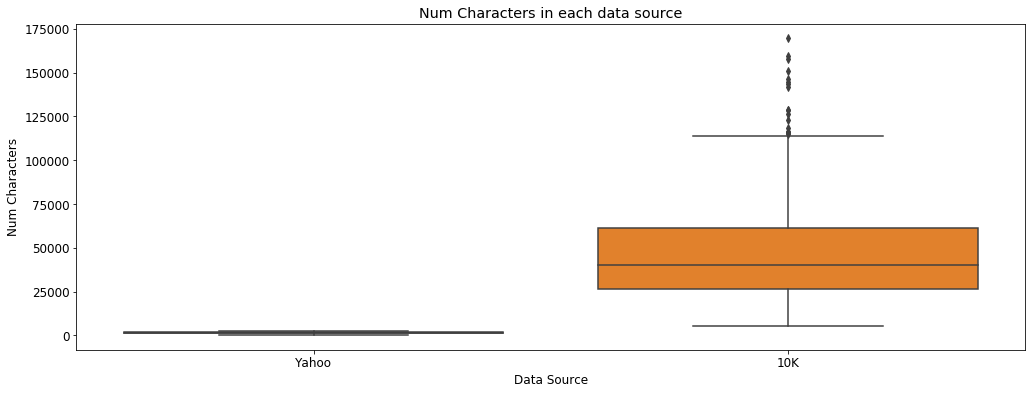

In [171]:
desc_lens = [df.Description.apply(len) for df in SNP_DESC_DFS]
len_df = pd.concat(desc_lens, axis=1)
len_df.columns = SNP_DATA_SRCS
# len_df.drop('10K', axis=1, inplace=True)
ax = sns.boxplot(data=len_df)
ax.set(ylabel="Num Characters", xlabel='Data Source')
ax.set_title('Num Characters in each data source')

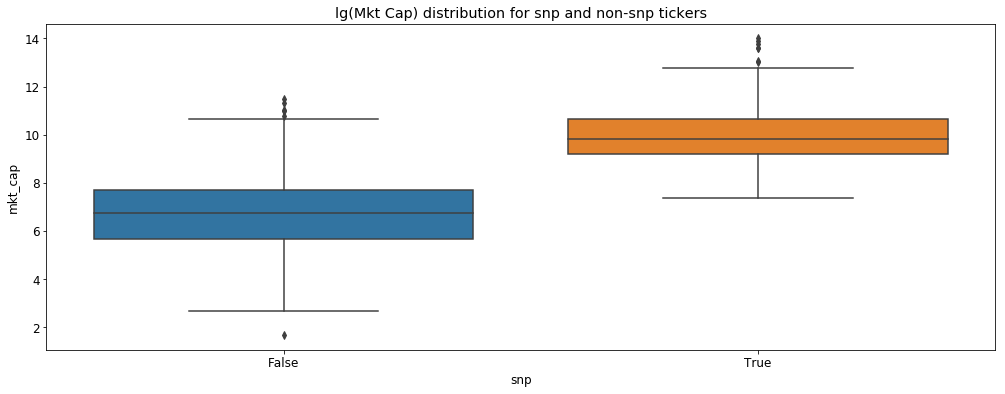

In [174]:
ticker_ratios_df = pd.read_csv('data_out/russell_ratios_clean.csv')
ticker_ratios_df.mkt_cap = np.log(ticker_ratios_df.mkt_cap)
ticker_ratios_df['snp']=ticker_ratios_df.Ticker.isin(snp_desc_yahoo_df.Ticker.values)
ticker_ratios_df['rus']=ticker_ratios_df.Ticker.isin(russell_desc_yahoo_df.Ticker.values)
ax = sns.boxplot(data=ticker_ratios_df, x='snp', y='mkt_cap')
ax.set_title('lg(Mkt Cap) distribution for snp and non-snp tickers')

# -----------------------------------------------------------------------------------------------------------------

# Global Vars: Tickers, Description, Classifier to be used

- put yahoo as 1st data_src as it also has sector and sub-industry classification (cos the STANDARD CLASSIFIER  will be used from the first element of DESC_DFS)
- if you just change the STANDARD_CLASSIFIER variable you can go jump to the 'Run all Clustering algos' header to continue running

In [753]:
# To Set
# INDEX = 'russell'
# DATA_SRCS = RUSSELL_DATA_SRCS
# DESC_DFS = RUSSELL_DESC_DFS

INDEX = 'snp'
DATA_SRCS = SNP_DATA_SRCS
DESC_DFS = SNP_DESC_DFS

STANDARD_CLASSIFIER = 'GICS' #GICS, Sector, Industry

In [754]:
desc_lists = [desc_df['Description'] for desc_df in DESC_DFS]
NUM_INDUSTRIES =  len(set(DESC_DFS[0][STANDARD_CLASSIFIER])) #69 for GICS

print(NUM_INDUSTRIES)

63


### Pre Processing

- Used Snowball stemmer as it is a slightly improved version of Porter stemmer
- lemmatization takes longer, and increases feature size

In [181]:
STOP_FILES = ['StopWords_GenericLong.txt', 'StopWords_DatesandNumbers.txt', 'StopWords_Geographic.txt', 
              'StopWords_Currencies.txt', 'StopWords_Names.txt']
STOP_WORDS = []

for file in STOP_FILES:
    df = pd.read_csv('data_in/Stop Words/%s'%file, sep='|',header=None,encoding='latin1')
    file_stop_words = list(df[0].str.lower().str.strip())
    STOP_WORDS.extend(file_stop_words)

STOP_WORDS.extend(stopwords.words('english'))
STOP_WORDS = set(STOP_WORDS)
len(STOP_WORDS)

12766

- Note for finance jargon we dont have much apostrophes (we can use the TweetTokeniser for that)

In [182]:
def get_wordnet_pos(nltk_pos):
    """Map POS tag to so lemmatize() accepts input"""
    tag = nltk_pos[0]
    NLTK_TO_WORDNET_POS = {"J": wordnet.ADJ,
                            "N": wordnet.NOUN,
                            "V": wordnet.VERB,
                            "R": wordnet.ADV}
    return NLTK_TO_WORDNET_POS.get(tag, wordnet.NOUN)

def preprocess_data(doc_list):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed document list
    """
    tokenizer = RegexpTokenizer(r'\w+')
    p_stemmer = PorterStemmer()
    s_stemmer = SnowballStemmer(language='english')
    lemmatizer = WordNetLemmatizer()
    processed_doc_list = []

    for doc in tqdm(doc_list):
        lower_doc = doc.lower()
        clean_doc = lower_doc.replace("_", "").replace('\n', ' ').replace(',', ' ')
        rem_num_doc = re.sub('[0-9]+', '', clean_doc)
        
        token_list = tokenizer.tokenize(rem_num_doc) # tokeniser removes special characters (except _)
        token_list = [i for i in token_list if len(i)>=3]
        stopped_token_list = [i for i in token_list if not i in STOP_WORDS]
#         word_reduced_token_list = [p_stemmer.stem(i) for i in stopped_token_list]
#         word_reduced_token_list = [s_stemmer.stem(i) for i in stopped_token_list]
        word_reduced_token_list = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) 
                                     for w, pos in nltk.pos_tag(stopped_token_list)]
        processed_doc = ' '.join(word_reduced_token_list) # Untokenize
        processed_doc_list.append(processed_doc)
    
    return processed_doc_list

In [183]:
preped_desc_lists = [preprocess_data(desc_list) for desc_list in desc_lists]

In [186]:
#Test
print(len(preped_desc_lists[0]))
preped_desc_lists[0][0]

465


'agilent technology application focus solution life science diagnostics applied chemical market worldwide operate segment life science apply market diagnostics genomics agilent crosslab life science apply market segment offer liquid gas chromatography system component liquid gas chromatography mass spectrometry system inductively couple plasma mass spectrometry instrument atomic absorption instrument microwave plasma atomic emission spectrometry instrument inductively couple plasma optical emission spectrometry instrument raman spectroscopy cell analysis plate base assay flow cytometer time cell analyzer cell image system microplate reader laboratory software information management analytics laboratory automation robotic system dissolution test vacuum pump measurement technology diagnostics genomics segment reagent instrument software consumables array dna mutation detection genotyping copy number determination identification rearrangement dna methylation profile expression profile seq

### Tdidf and Bag of Words (BOW) vectorization

- using max_df and min_df significantly reduced feature size
- using lemmatization increased feature size
- normalisation of vectors is done in this step (account for diff lengths of desc)

<font size="5">
$$
idf(t,D) = log(\frac{1 + |D|}{1 + \mid d \in D: t \in d \mid}) + 1
$$
</font>

- This is sk learns implementation (different from classic formulation)
- a term appearing in 1 or 2 docs have a bigger impact in idf than eg 30 or 31 docs which is how it should be

In [282]:
# TDIDF
vectorizer = TfidfVectorizer(stop_words='english', max_features= None, max_df = 0.5, min_df=2, smooth_idf=True,
                             ngram_range=(1,1), norm='l2') 
# dtm - Document Term Matrix (sparse matrix)
# Note: Attributes of vectorizer will be from the last prepped_desc_only
dtms = [vectorizer.fit_transform(preped_desc_list) for preped_desc_list in preped_desc_lists]

In [608]:
# BOW
tf_vectorizer = CountVectorizer(stop_words='english', max_features= None, max_df = 0.5, min_df=2)
dtms_tf = [tf_vectorizer.fit_transform(preped_desc_list) for preped_desc_list in preped_desc_lists]

In [609]:
shapes = [dtm.shape for dtm in dtms_tf]
pd.DataFrame(shapes, index=DATA_SRCS, columns=['num_row', 'num_col (vector length)'])

,num_row,num_col (vector length)
Yahoo,465,2976
10K,465,13880


| Descriptions | Unique Words (features)
| :- | -: | 
| SnP (10K) | 13880 |
| SnP (yahoo) | 2976 |
| Russell (10K) | 78546 |
| Russell (yahoo) | 16855 |
| Russell (10K, from previous project) | 20025 |


- Feature counts for different pre-processing methods: (using df = (0.5, 2) with Yahoo Descriptions )
    - porter stemer : 10870
    - snowball stemer : 10877
    - lemmatization : 14315

###### Check if words used in tdidf model are meaningful by looking at most infrequent and frequent words (i.e. using Inverse Document Frequency (IDF))

In [189]:
features = vectorizer.get_feature_names()
features_df = pd.DataFrame(vectorizer.idf_, columns=['IDF'], index=features)
features_df.sort_values('IDF', inplace=True)
display(features_df.head(100))
display(features_df.tail(100))
display(features_df)

,IDF
govern,1.693147
administration,1.693147
restriction,1.693147
professional,1.697448
tool,1.697448
joint,1.697448
senior,1.697448
secure,1.697448
promote,1.697448
domestic,1.697448


,IDF
flutter,6.045573
puppet,6.045573
fmt,6.045573
fnma,6.045573
pwg,6.045573
radv,6.045573
pwi,6.045573
floral,6.045573
fleas,6.045573
flier,6.045573


,IDF
govern,1.693147
administration,1.693147
restriction,1.693147
professional,1.697448
tool,1.697448
...,...
ration,6.045573
fhlbs,6.045573
fhlmc,6.045573
ratchet,6.045573


# DTM Visualisation

- visualise data in 2D using PCA and LSI to see which clustering approach will work best
- look at GICS Sector classification (for easier visualisation as there are only 11 classes)

In [284]:
dtm = dtms[0].toarray()
# dtm = Normalizer(norm='l2').fit_transform(dtm)

pca = PCA(n_components=2, random_state=0)
dtm_pca = pca.fit_transform(dtm)
dtm_pca = StandardScaler().fit_transform(dtm_pca)# z-score of features (not samples) 

lsi = TruncatedSVD(2, algorithm = 'arpack', random_state=0)
dtm_lsi = lsi.fit_transform(dtm)
dtm_lsi_normalised = Normalizer(norm='l2').fit_transform(dtm_lsi) # normalisae so each vector is len 1 (sample norm) #not good!!

In [193]:
pca2 = PCA(n_components=0.5, random_state=0) #Choose components to explain 50% of the variance
dtm_pca2 = pca2.fit_transform(dtm)
len(pca2.explained_variance_ratio_)

86

- ~85 components required to explain 50% of variance in data
- Possible idea is to weight features by the explained variance when calculating distances

In [224]:
MARKERS = ['D','o','v','^','<','X','*','h','s','p','P']
len(markers)

11

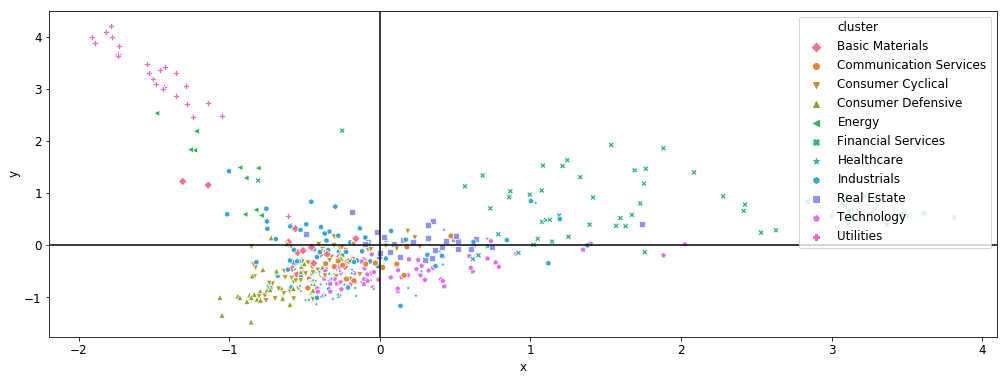

In [252]:
df = pd.DataFrame(X, columns=['x', 'y'])
df['cluster'] = DESC_DFS[0].Sector
# plt.figure(figsize=(14,10))
ax = sns.scatterplot(x='x', y='y', hue='cluster', style='cluster', markers=MARKERS , data=df) #relplot(col='cluster',col_wrap=3)
ax.axhline(0, color='black')
ax.axvline(0, color='black')

- seems distance to center matters, so scaling (the output) might remove important information
- but normalising the output is important to account for the different scales of features after LSI so that distancing makes sense
- the clusters seem to be spread from the (0,0) point (not sure how to implement distance measure to make it robust to handle such a clustering pattern)


- Normalising
    - scale vectors to unit length (L1/L2 defn)
    - Normaliser() has got nothing to do with normal distribution
    - sklearn documnetation does this after SVD (https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)
        - but i think this is not good for this problem
    - vectors are also normalised after TDIDF
- Standardising (StandardScaler())
    - Z score fof FEATURES!


- Distance metrics
    - cosine distance
        - i think cosine distance can be uninformative for points near the center
    - correlation distance
        - 1-r
        - diff with cosine dist is that this is invariance to scaling AND translation
    - Manhattan distance (L1 dist)
        - good for sparse features (like dtms for text mining) since most of the features are 0
    - others (usu for distributions)
        - hellinger
        - KL distance
        - Jaccard Similarity
        
- normalising before SVD seems to separate points better
- You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution
        

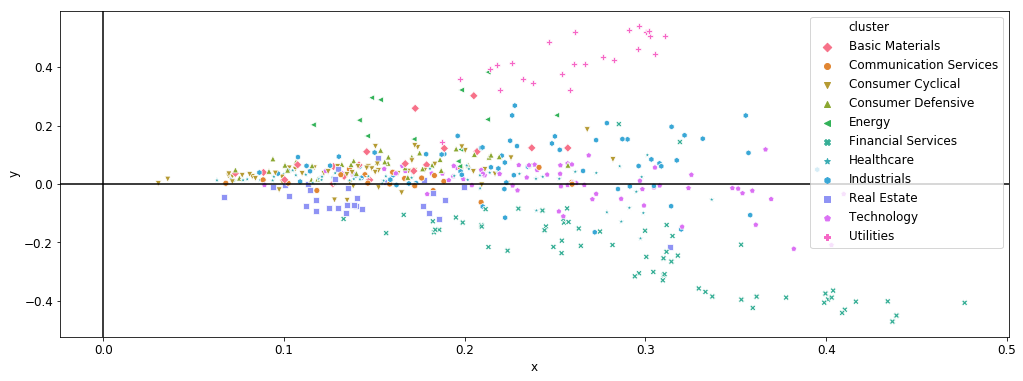

In [229]:
df = pd.DataFrame(dtm_lsi, columns=['x', 'y'])
df['cluster'] = DESC_DFS[0].Sector
# plt.figure(figsize=(14,10))
ax = sns.scatterplot(x='x', y='y', hue='cluster', style='cluster', markers=MARKERS, data=df)
ax.axhline(0, color='black')
ax.axvline(0, color='black')

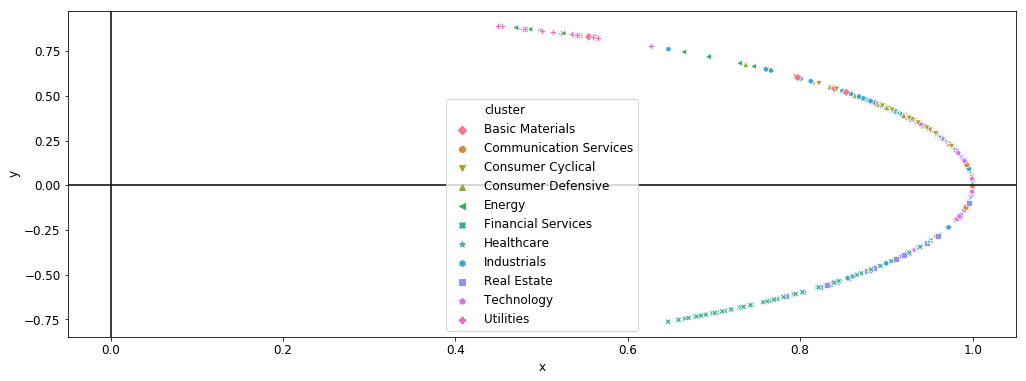

In [242]:
df = pd.DataFrame(dtm_lsi_normalised, columns=['x', 'y'])
df['cluster'] = DESC_DFS[0].Sector
# plt.figure(figsize=(14,10))
ax = sns.scatterplot(x='x', y='y', hue='cluster', style='cluster', markers=MARKERS, data=df)
ax.axhline(0, color='black')
ax.axvline(0, color='black')

# Topic Modelling

- leveraging the idea that meaning can be extracted from context (ie words from the same document should have some similarity)
- Methods
    - Latent Semantic Indexing/Analysis (LSA/LSI)
        - uses SVD
    - PCA
        - also SVD (but PCA does SVD on the covariance matrix)
        - PCA is more general and can be used on high dimentional datasets  while LSI is more specific to text corpora
    - Latent Dirichlet Allocation
         - relies on probabilistic graphical modelling
         - only uses BOW (not TDIDF)
    - Non Negative Matrix Factorization (NMF)
        - relies on Linear Algebra

## Determine Optimal Number of Topics

We will try: 
- Top n words (human eye balling)
- Coherence score

### Top n words

- both gensim and sklearn implementation provided (similar)

##### gensim implementation

- has inbuilt visualisation tool

In [602]:
NUM_TOPICS = 11
tokenized_desc_list = [word_tokenize(doc) for doc in preped_desc_lists[0]]
dictionary = corpora.Dictionary(tokenized_desc_list)
dtm_gensim = [dictionary.doc2bow(doc) for doc in tokenized_desc_list] #this dtm has a unique structure
# model = LsiModel(dtm_gensim, num_topics=num_topics, id2word=dictionary)
model = LdaMulticore(corpus=dtm_gensim, id2word=dictionary, num_topics=NUM_TOPICS, random_state=0, chunksize=100, passes=10, per_word_topics=True)
model.print_topics(num_words=5)

[(0,
  '0.044*"product" + 0.029*"company" + 0.022*"store" + 0.018*"brand" + 0.013*"offer"'),
 (1,
  '0.019*"service" + 0.017*"company" + 0.012*"segment" + 0.011*"product" + 0.010*"freight"'),
 (2,
  '0.023*"service" + 0.013*"test" + 0.013*"company" + 0.012*"insurance" + 0.011*"offer"'),
 (3,
  '0.030*"service" + 0.028*"company" + 0.026*"product" + 0.020*"segment" + 0.013*"offer"'),
 (4,
  '0.031*"product" + 0.020*"company" + 0.013*"segment" + 0.009*"paper" + 0.008*"packaging"'),
 (5,
  '0.066*"service" + 0.023*"company" + 0.023*"management" + 0.021*"segment" + 0.019*"banking"'),
 (6,
  '0.027*"investment" + 0.019*"service" + 0.018*"fund" + 0.015*"segment" + 0.015*"insurance"'),
 (7,
  '0.027*"company" + 0.020*"service" + 0.014*"product" + 0.012*"operate" + 0.011*"offer"'),
 (8,
  '0.032*"company" + 0.029*"gas" + 0.022*"product" + 0.019*"natural" + 0.018*"segment"'),
 (9,
  '0.022*"segment" + 0.019*"product" + 0.018*"system" + 0.014*"service" + 0.012*"water"'),
 (10,
  '0.030*"system" +

In [603]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(model, dtm_gensim, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.019040  0.031987       1        1  20.353703
10    -0.117288  0.127454       2        1  19.542285
8     -0.089706  0.078094       3        1  12.534869
5      0.158620  0.086943       4        1  10.649190
0     -0.029177 -0.158039       5        1   8.555780
7     -0.053077 -0.067786       6        1   7.626595
9     -0.092349  0.069172       7        1   5.457423
6      0.222668  0.012834       8        1   5.036260
1     -0.028337 -0.029028       9        1   4.062037
4     -0.013020 -0.153843      10        1   3.751491
2      0.022626  0.002210      11        1   2.430366, topic_info=            Term         Freq        Total Category  logprob  loglift
95       service  1342.000000  1342.000000  Default  30.0000  30.0000
47           gas   223.000000   223.000000  Default  29.0000  29.0000
104       system   526.000000   526.000000  Default  28.0000  28.0000
1004  investment   163.000000   163.000000  Default  27.0000  27.0000
642    insurance   205.000000   205.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
305     personal     5.014415    77.724647  Topic11  -5.5962   0.9763
159        brand     4.904256   167.394461  Topic11  -5.6184   0.1869
474    primarily     4.738034   111.015812  Topic11  -5.6529   0.5631
138   subsidiary     4.720623   110.983830  Topic11  -5.6566   0.5597
285         home     4.497073   148.391577  Topic11  -5.7051   0.2207

[801 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1563      7  0.921946   academic
140       1  0.058236  accessory
140       2  0.281474  accessory
140       3  0.019412  accessory
140       5  0.378534  accessory
...     ...       ...        ...
4638     10  0.525291      write
4638     11  0.131323      write
6603     11  0.738818      xandr
7173      8  0.875910      xylem
7201      4  0.765086       zion

[1919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 9, 6, 1, 8, 10, 7, 2, 5, 3])

- can use this to add financial stop words
    - eg: company

##### sklearn implementation

In [604]:
lsi_test = TruncatedSVD(n_components=11, algorithm = 'arpack', random_state=0)
dtm_lsi_test = lsi_test.fit_transform(dtms[-1]) # use -1 becos the vectorier's features will be of that it trained last

features = vectorizer.get_feature_names()
topic_words = []
topic_components = lsi_test.components_
for i, comp in enumerate(topic_components):
    terms_comp = zip(features, comp)
    sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    sorted_words_clean = [tup[0] for tup in sorted_words]
    topic_words.append(sorted_words_clean)
topic_df = pd.DataFrame(topic_words, index=['Topic %d'%i for i in range(topic_components.shape[0])])

In [605]:
topic_df

,0,1,2,3,4,5,6
Topic 0,insurance,client,bank,president,store,gas,care
Topic 1,bank,banking,institution,client,fdic,insurance,reserve
Topic 2,patient,clinical,drug,fda,care,medical,pharmaceutical
Topic 3,gas,natural,electric,pipeline,utility,ferc,patient
Topic 4,insurance,client,reinsurance,insurer,annuity,casualty,premium
Topic 5,store,tenant,merchandise,insurance,reit,estate,apartment
Topic 6,tenant,reit,estate,lease,apartment,rent,rental
Topic 7,client,store,gas,merchandise,natural,electric,utility
Topic 8,television,fcc,broadcast,video,store,entertainment,wireless
Topic 9,airline,president,television,aircraft,broadcast,fcc,entertainment


- words seem pretty sensible
- n_components is the number of topics to be extracted, so you shd use 64

### Coherence Score

- Topic Coherence measures degree of semantic similarity between high scoring words in each topic
- there are various coherence measures
    - coherence values are calculated as the sum of pairwise scores of top n words used to describe a topic for all measures
    - most popular are c_v and u_mass, with c_v being more accurate and u_mass being faster
    - c_v
        - [0,1]
        - 0.7 is a good topic coherence score to aim for
        - uses normalised pointwise mutual information (NPMI)
    - u_mass
        - intrinsic measure
        - similar, using pairwise score function
        - [-14,14]
        - the closer to 0 the better the topics
    - UCI
        - extrinsic measure
        - using external information (eg wikipedia) to determine word similarities
        - pointwise mutual information (PMI)
    
        

- Choosing ‘k’ that marks end of rapid growth of topic coherence usually offers meaningful and interpretable topics
- We use Gensim as sklearn does not have inbuilt coherence score calculator

In [ ]:
tokenized_desc_list = [word_tokenize(doc) for doc in preped_desc_lists[0]]
dictionary = corpora.Dictionary(tokenized_desc_list)
dictionary.filter_extremes(no_below=2, no_above=0.5)
dtm_tf = [dictionary.doc2bow(doc) for doc in tokenized_desc_list]
dtm_tdidf = TfidfModel(dtm_tf)[dtm_tf]

def model_coherence_scores(model):
    coherencemodel = CoherenceModel(model=model, texts=tokenized_desc_list, dictionary=dictionary, coherence='c_v') # randomness exists
    cv = coherencemodel.get_coherence()
    coherencemodel = CoherenceModel(model=model, texts=tokenized_desc_list, dictionary=dictionary, coherence='u_mass')
    um = coherencemodel.get_coherence()
    return [cv, um]

In [659]:
coherence_scores = []
NUM_TOPICS_RNG = range(2,30, 1)    

for num_topics in tqdm(NUM_TOPICS_RNG):
    scores = []
    # LSI
    model = LsiModel(dtm_tdidf, num_topics=num_topics, id2word=dictionary)
    scores.extend(model_coherence_scores(model))
    # LDA (note we use dtm_tf not dtm_tfidf)
    model = LdaMulticore(corpus=dtm_tf, id2word=dictionary, num_topics=num_topics, random_state=0,
                                       chunksize=100, passes=10, per_word_topics=True)
    scores.extend(model_coherence_scores(model))
    # NMF
    model = Nmf(corpus=dtm_tdidf, num_topics=num_topics, id2word=dictionary, chunksize=2000, passes=5, kappa=.1, 
                minimum_probability=0.01, w_max_iter=300, w_stop_condition=0.0001, h_max_iter=100, h_stop_condition=0.001,
                eval_every=10, normalize=True, random_state=0)
    scores.extend(model_coherence_scores(model))
    coherence_scores.append(scores)
    
coherence_df = pd.DataFrame(coherence_scores, columns=['lsi_cv', 'lsi_umass', 'lda_cv', 'lda_umass', 'nmf_cv', 'nmf_umass'], index=NUM_TOPICS_RNG)

KeyboardInterrupt: 

In [658]:
coherence_df.to_csv('data_out/results/snp_coherence.csv')
# coherence_df = pd.read_csv('data_out/results/snp_coherence.csv', index_col=0)
coherence_df.head()

,lsi_cv,lsi_umass,lda_cv,lda_umass,nmf_cv,nmf_umass
0,0.512568,-1.481011,0.407977,-1.338345,0.257220,-2.896860
1,0.631022,-6.570520,0.485356,-1.338272,0.411390,-2.512145
2,0.612739,-2.427415,0.507163,-1.659515,0.511901,-2.330711
3,0.538413,-2.762736,0.516430,-1.605748,0.538236,-2.285135
4,0.527868,-5.490530,0.510204,-1.512810,0.587533,-2.427758
5,0.605099,-5.382760,0.506651,-1.704990,0.519432,-2.804053
6,0.581786,-3.202380,0.529628,-1.902840,0.534912,-2.293443
7,0.447374,-3.748060,0.501539,-1.965067,0.552262,-3.154010


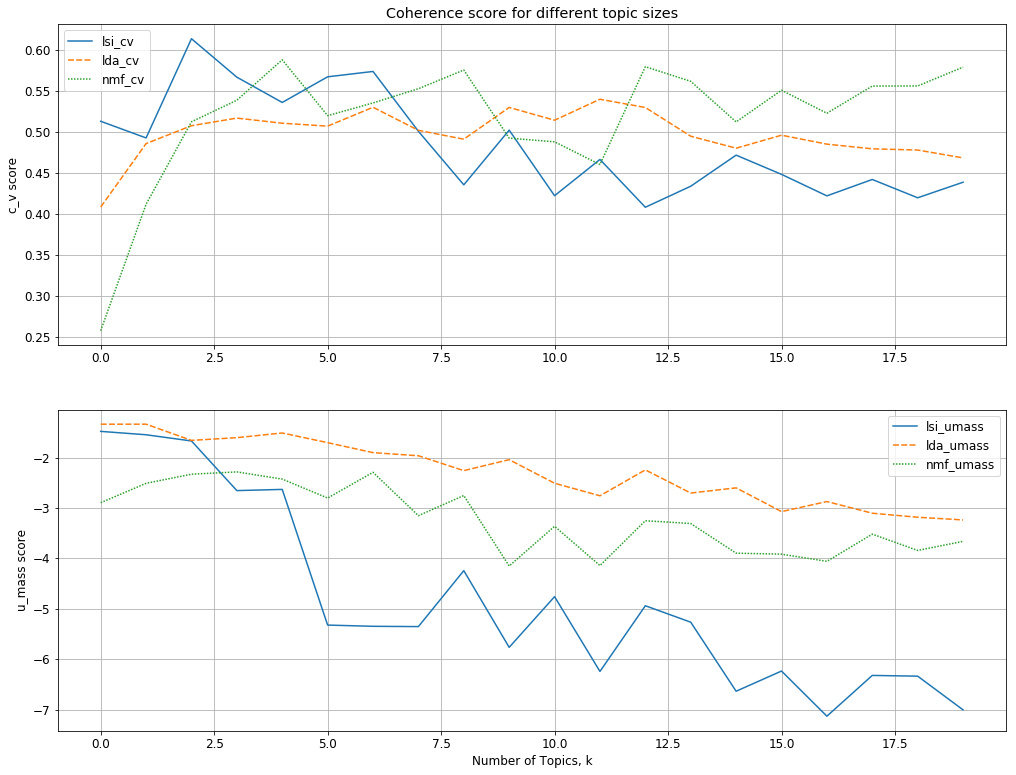

In [663]:
TITLE = 'Coherence score for different topic sizes'
plt.figure(figsize=(17,13))

plt.subplot(211)
ax = sns.lineplot(data=coherence_df[['lsi_cv', 'lda_cv', 'nmf_cv']])
ax.set(ylabel='c_v score')
ax.grid()
plt.title(TITLE)

plt.subplot(212)
ax = sns.lineplot(data=coherence_df[['lsi_umass', 'lda_umass', 'nmf_umass']])
ax.set(ylabel='u_mass score', xlabel='Number of Topics, k')
ax.grid()
# plt.savefig('data_out/images/' + TITLE)

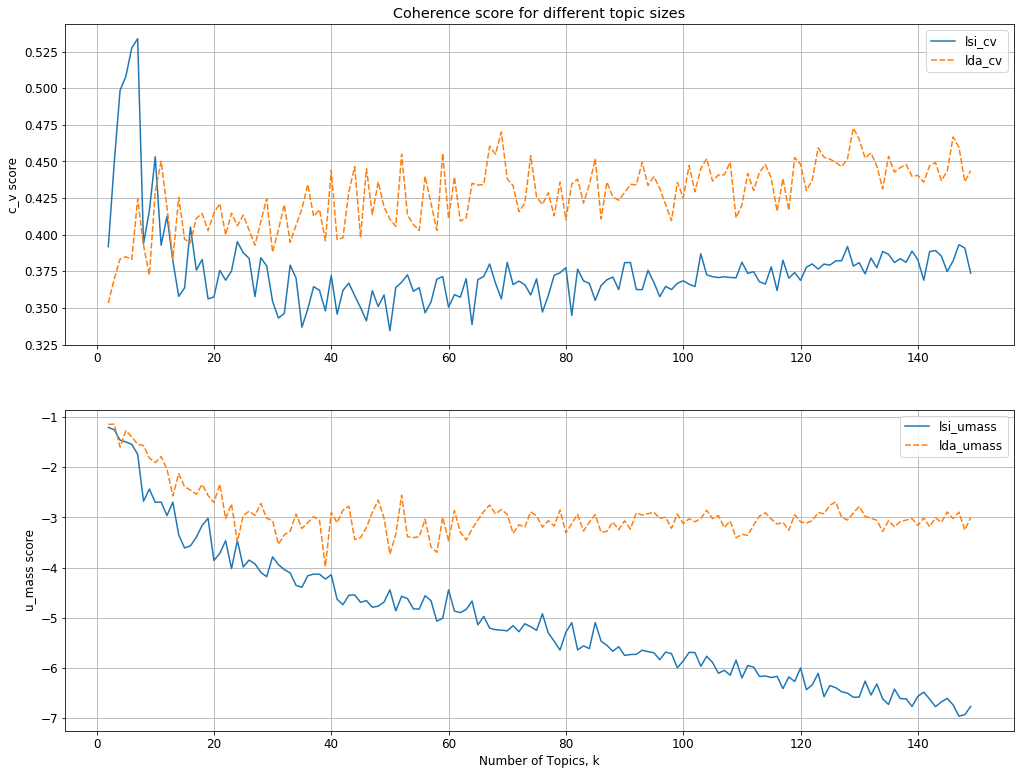

In [579]:
TITLE = 'Coherence score for different topic sizes'
plt.figure(figsize=(17,13))

plt.subplot(211)
ax = sns.lineplot(data=coherence_df[['lsi_cv', 'lda_cv', 'nmf_cv']])
ax.set(ylabel='c_v score')
ax.grid()
plt.title(TITLE)

plt.subplot(212)
ax = sns.lineplot(data=coherence_df[['lsi_umass', 'lda_umass', 'nmf_umass']])
ax.set(ylabel='u_mass score', xlabel='Number of Topics, k')
ax.grid()
plt.savefig('data_out/images/' + TITLE)

- LSI performs very well for topics less than 10
    - 2,7 topics seems to be best for LSI
- LDA seems to perform slightly better for topics greater than 10

# Clustering Algos

### K-Means

- uses Euclidean distances by implementation (cant change)
- sklearn also has MiniBatchKMeans, which is faster but results are not as good
- since k means choses centroids to minimises inertia (within cluster sum of squares - shows how coherent clusters are) it works better with convex clusters. Works poorly with elongated, irregular shaped clusters

In [290]:
def kmeans_cluster(dtm, n_clusters=NUM_INDUSTRIES):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(dtm)
    return kmeans.labels_

### K-medioids

- aka partitioning around medoids (PAM)
- K-means choses point average as cluster center while k-medoids chooses data points as centers (medoids)
    - thus k-medioids works with arbitraty distances while k-means only works with euclidean dist
    - A medoid is an element in a cluster whose average dissimilarity to all objects in cluster is minimal (i.e most centrally located point in cluster)
- more robust to noise and outliers as compared to k-means because it minimizes a sum of pairwise dissimilarities instead of a sum of squared Euclidean distances

In [292]:
def get_cluster_allocation_from_clusters(clusters):
    num_elemts = max(functools.reduce(lambda x,y: x+y, clusters)) + 1
    idx_clusters = np.zeros(num_elemts).astype(int)
    i = 0
    for cluster in clusters:
        idx_clusters[cluster] = i
        i +=1
    return idx_clusters

In [293]:
def kmedioids_cluster(dtm, n_clusters=NUM_INDUSTRIES):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
#     cosine_distance = lambda x, y: distance.cosine(x,y)
#     metric = distance_metric(type_metric.USER_DEFINED, func=cosine_distance)
    metric = distance_metric(type_metric.EUCLIDEAN)
    initial_medoids = list(range(n_clusters))
    
    kmedoids_instance = kmedoids(dtm, initial_medoids, metric=metric)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    cluster_allocation = get_cluster_allocation_from_clusters(clusters)
    return cluster_allocation

### K-medians

In [294]:
def kmedians_cluster(dtm):
    initial_medians = dtm[:NUM_INDUSTRIES]
    kmedians_instance = kmedians(dtm, initial_medians)
    kmedians_instance.process()
    clusters = kmedians_instance.get_clusters()
    medians = kmedians_instance.get_medians()
    cluster_allocation = get_cluster_allocation_from_clusters(clusters)
    return cluster_allocation

### DBSCAN

- Usecase: Non-flat geometry, uneven cluster sizes

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# X = StandardScaler().fit_transform(dtm)

# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

### Gaussian Mixture

- kmeans is a distance based model, while gmm is a distribution based model

In [295]:
def gmm_cluster(dtm, n_clusters=NUM_INDUSTRIES):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    gmm.fit(dtm)
    pred = gmm.predict(dtm)
    return pred

### Agglomerative Clustering

- before applying Hierarchical Clustering, normalize data so that scale of variable are same (If variable scale not same, model might be biased to variables with a higher magnitude)
    - dont think this is important if you use cosine distance

In [296]:
def agglomerative_cluster(dtm, n_clusters=NUM_INDUSTRIES):
    ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    ac.fit(dtm)
    return ac.labels_

## Test Cluster Allocation for different clustering algos

### Clustering Evaluation Metrics

** Based on ground truth ** 
- Adjusted Random Index
    - similarity between 2 clusterings (ignoring permutations, with chance normalization)
    - [-1,1]
    - random assignment will have value 0
- Adjusted Mutual Information/ Normalised Mutual Info (AMI/NMI)
    - similar to ARI, but diff mathematical expression
    - UB of 1, if <=0 means independent labelling
- homogeneity and completeness score
    - homogenety: each prediciton cluster contains only members of a single true class
    - completeness: each true class contains only members of one prediction class
    - [0,1]
    - not normalised wrt randomised labelling
        - random labelling wont yield 0 scores esp when n_cluster is large (better to use ARI)
        - good for large sample size and small n_clusters
    - order matters
        - homogeneity_score(a, b) == completeness_score(b, a)
- V measure
    - Harmonic mean of abv 2 scores
 
** Not based on ground truth ** 

- Silhoutte Score
    - measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)
    - find silhoutte coefficient for each sample and average
        - near 1: far from neighbouring clusters
        - 0: close to decision boundary between clusters
        - -ve: sample might be assigned to wrong cluster
    - [-1,1]
    - used in silhoutte analysis to determine number of clusters
    - generall higher for convex clusters than other concepts of clusters (eg density based clusters)
- inertia
    

In [456]:
def perp_cluster_names(cluster_allocation):
    return list(map(lambda j: 'Cluster ' + str(j), cluster_allocation))

dtm = dtms[0].toarray()

# Topic Modelling
TOPICS = 10
# model = PCA(n_components=TOPICS, random_state=0)
model = TruncatedSVD(TOPICS, algorithm = 'arpack', random_state=0)
dtm = model.fit_transform(dtm)

# dtm = StandardScaler().fit_transform(dtm) # not good Silhouette Coefficient
dtm = Normalizer(norm='l2').fit_transform(dtm)

# Clustering
cluster_allocation = kmeans_cluster(dtm, n_clusters=11)
# cluster_allocation = kmedioids_cluster(dtm, n_clusters=11)
# cluster_allocation = gmm_cluster(dtm, n_clusters=11)
# cluster_allocation = agglomerative_cluster(dtm, n_clusters=11)
cluster_allocation_names = perp_cluster_names(cluster_allocation)

# cluster_allocation_names = DESC_DFS[0].Sector

# Graphing
pca = PCA(n_components=2, random_state=0)
dtm_pca = pca.fit_transform(dtm)

In [455]:
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(DESC_DFS[0].Sector, cluster_allocation))
print("Adjusted Mutual Info: %.3f" % metrics.adjusted_mutual_info_score(DESC_DFS[0].Sector, cluster_allocation))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(DESC_DFS[0].Sector, cluster_allocation))
print("Completeness: %0.3f" % metrics.completeness_score(DESC_DFS[0].Sector, cluster_allocation))
print("V-measure: %0.3f" % metrics.v_measure_score(DESC_DFS[0].Sector, cluster_allocation))

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(dtm, DESC_DFS[0].Sector))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(dtm, cluster_allocation))

Adjusted Rand-Index: 0.404
Adjusted Mutual Info: 0.573
Homogeneity: 0.611
Completeness: 0.594
V-measure: 0.603
Silhouette Coefficient: 0.186
Silhouette Coefficient: 0.368


- PCA does not give good silhouette score for GICS classification 
- adding Normalizer after SVD_10 makes similarity with GICS better and silhouette for both clustering better

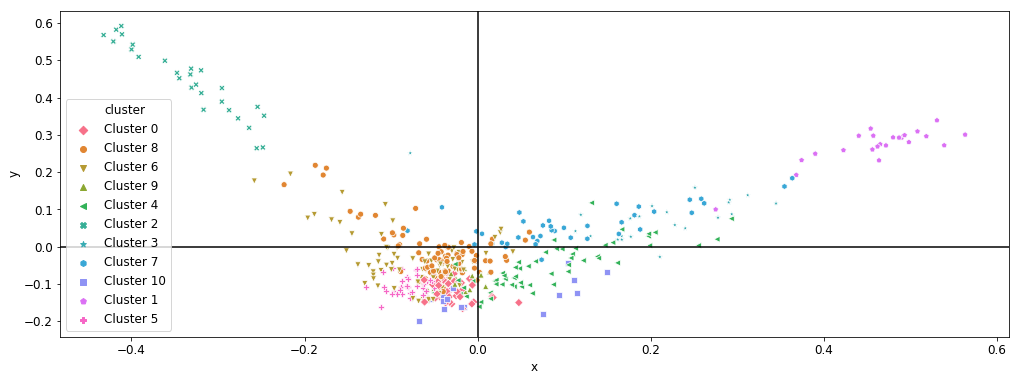

In [458]:
df = pd.DataFrame(dtm_pca, columns=['x', 'y'])
df['cluster'] = cluster_allocation_names
# plt.figure(figsize=(14,10))
ax = sns.scatterplot(x='x', y='y', hue='cluster', style='cluster', markers=MARKERS, data=df)
ax.axhline(0, color='black')
ax.axvline(0, color='black')

# Determine Optimal Number of Clusters

- using kmeans

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

gics_sil_score = metrics.silhouette_score(dtm_lsi_test, desc_df.GICS)

silhouette_coefficients = []
sse = []
iters = []
a,b = 2,200
for k in tnrange(a,b):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dtm_lsi_test)
    score = metrics.silhouette_score(dtm_lsi_test, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    iters.append(kmeans.n_iter_) # dosent give much information usu from [4,20]


In [ ]:
plt.plot(range(a, b), sse)
plt.xticks(range(a, b,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid()
plt.show()

- can see there is a slight elbow at 11

In [ ]:
plt.plot(range(a,b), silhouette_coefficients, label='k-means')
plt.axhline(gics_sil_score, label='GICS', color='r')
plt.xticks(range(a,b,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.show()

- best score at 112, which is the number of subindustries
- k-means easily outperforms GICS for silhouette coefficient, which makes sense as k-means is clustering wrt to the given vectors so it should in a sense optimise the silhouette coefficient

# Run all Clustering algos

- not sure if i should do the normalising before LSI or after (note we are doing samplewise normalisation not feature wise normalisation)
    - some suggest normalising before and after

In [ ]:
#Test
dtms[0].shape

In [758]:
TOPIC_MODELS = ['lsi', 'lda', 'nmf', 'pca']
def get_topic_model(name, k):
    MODEL_DICT = {
        'lsi' : TruncatedSVD(n_components=k, algorithm = 'arpack', random_state=0),
        'lda' : LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0),
        'nmf' : NMF(n_components=k, random_state=0, alpha=.1, l1_ratio=.5, init='nndsvd'),
        'pca' : PCA(n_components=k, random_state=0)
    }
    return MODEL_DICT.get(name, None)

CLUSTERING_MODELS = {
    'kmeans' : kmeans_cluster,
    'kmedioids' : kmedioids_cluster,
    'agglomerative' : agglomerative_cluster,
    'gmm' : gmm_cluster
}    

In [757]:
std_class_df = pd.DataFrame(DESC_DFS[0][STANDARD_CLASSIFIER].cat.codes, columns=[STANDARD_CLASSIFIER])
cluster_dfs_list = [DESC_DFS[0][['Ticker']], std_class_df]
for i in tnrange(len(DATA_SRCS)):
    data_src = DATA_SRCS[i]
    dtm = dtms[i]
    for k in tnrange(25, 100, 50):
        for topic_model_name in TOPIC_MODELS:
            topic_model = get_topic_model(topic_model_name, k)
            if topic_model_name == 'pca':
                dtm_k = topic_model.fit_transform(dtm.toarray())
            else:
                dtm_k = topic_model.fit_transform(dtm)
            dtm_k = Normalizer().fit_transform(dtm_k)
            for cluster_model_name, cluster_model in CLUSTERING_MODELS.items():
                clusters_k = cluster_model(dtm_k)
                cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['%s_%s_%d_%s'% (data_src, topic_model_name, k,cluster_model_name)]))
            
all_cluster = pd.concat(cluster_dfs_list, axis=1)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [759]:
all_cluster.head()

,Ticker,GICS,Yahoo_lsi_25_kmeans,Yahoo_lsi_25_kmedioids,Yahoo_lsi_25_agglomerative,Yahoo_lsi_25_gmm,Yahoo_lda_25_kmeans,Yahoo_lda_25_kmedioids,Yahoo_lda_25_agglomerative,Yahoo_lda_25_gmm,...,10K_lda_75_agglomerative,10K_lda_75_gmm,10K_nmf_75_kmeans,10K_nmf_75_kmedioids,10K_nmf_75_agglomerative,10K_nmf_75_gmm,10K_pca_75_kmeans,10K_pca_75_kmedioids,10K_pca_75_agglomerative,10K_pca_75_gmm
0,A,43,15,0,0,28,46,0,46,47,...,60,23,62,0,16,16,37,0,53,37
1,AAL,2,58,1,46,49,48,47,6,60,...,9,48,23,1,21,34,17,25,57,17
2,AAP,60,22,52,18,44,36,2,13,47,...,1,48,5,2,23,14,26,2,30,26
3,AAPL,61,54,3,2,27,44,3,56,47,...,18,48,60,13,2,1,13,9,22,13
4,ABBV,7,7,59,56,6,44,4,56,47,...,3,37,33,28,10,7,3,4,23,3


###### Save clustering to the next available file by index

In [ ]:
def smart_save(df, folder, start_word, data_name):
    file_list = os.listdir(folder)
    max_idx = -1
    for file in file_list:
        split_list = file.split('_')
        if split_list[0] == start_word:
            idx = int(split_list[-1][:-4])
            max_idx = max(max_idx, idx)

    savepath = '%s/%s_%s_%d.csv'%(folder, start_word, data_name, max_idx + 1)
    df.to_csv(savepath, index=False)
    print('Saved to: %s'%savepath)

In [ ]:
smart_save(all_cluster, 'data_out/all_clusters', INDEX, 'clusters')

# Evaluation

In [ ]:
# all_cluster = pd.read_csv('data_out/all_clusters/snp_clusters_2.csv')
# all_cluster.head()

### Method 1 - Ticker returns correlations

- regression of the daily return series of each stock with the return of the industry that the stock belongs to
- criterion is the the average of all R2s from the universe
- 5 years of daily returns used (same as previous project)

In [ ]:
ticker_price_df = pd.read_csv('data_in/russell_price.csv', index_col=0) 
# Can use this path for SnP: 'data_out/ticker_price_df.csv'

In [ ]:
ticker_price_df.columns = ticker_price_df.columns.str.replace('/', '-')
ticker_return_df = ticker_price_df.pct_change()
ticker_return_df

In [ ]:
# Tickers to remove if no ticker data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in ticker_return_df.columns]
print(tickers_with_no_data)

In [ ]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
print(all_cluster_filtered.shape)
all_cluster_filtered.head()

In [ ]:
mtds_R2_list = []

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    R2_list = []
    for i in range(NUM_INDUSTRIES):
        cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
        cluster_ticker_returns = ticker_return_df[cluster_tickers]
        mean_return = cluster_ticker_returns.mean(axis=1)
        cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
        R2_list.extend(cluster_R2)
    avg_R2 = sum(R2_list)/len(R2_list)
    if cluster_mtd == STANDARD_CLASSIFIER:
        STANDARD_CLASSIFIER_R2 = avg_R2
    else:
        data_src, _, k, clustering_mtd = cluster_mtd.split('_')
        mtds_R2_list.append([data_src, int(k), clustering_mtd, avg_R2])

avg_R2_df = pd.DataFrame(mtds_R2_list, columns=['Data_src', 'k', 'Clustering mtd', 'Average R2'])

In [ ]:
avg_R2_df.head()

In [ ]:
folder = 'data_out/results'
os.listdir(folder)

In [ ]:
smart_save(avg_R2_df, 'data_out/results', INDEX, 'R2')

In [ ]:
grp_df = avg_R2_df.groupby('Data_src')
best_R2_df = grp_df.apply(lambda df: df[df['Average R2'] == df['Average R2'].max()])
best_R2_df = best_R2_df.droplevel(level=1).drop('Data_src', axis=1)
best_R2_df['pct_cng'] = (best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2)/STANDARD_CLASSIFIER_R2 * 100
best_R2_df['abs_cng'] = best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2
best_R2_df.sort_values('pct_cng', inplace=True, ascending=False)
best_R2_df

- best values occur at low k values, and usually k means

In [ ]:
TITLE = 'R2 results - Clustering SnP (by GICS)'
print('GICS R2: %.3f'%STANDARD_CLASSIFIER_R2)
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_R2, color="black", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
grp_df = avg_R2_df.groupby('Data_src')
best_R2_df = grp_df.apply(lambda df: df[df['Average R2'] == df['Average R2'].max()])
best_R2_df = best_R2_df.droplevel(level=1).drop('Data_src', axis=1)
best_R2_df['pct_cng'] = (best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2)/STANDARD_CLASSIFIER_R2 * 100
best_R2_df['abs_cng'] = best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2
best_R2_df.sort_values('pct_cng', inplace=True, ascending=False)
best_R2_df

In [ ]:
TITLE = 'R2 results - Clustering SnP (by GICS)'
print('GICS R2: %.3f'%STANDARD_CLASSIFIER_R2)
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_R2, color="black", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
grp_df = avg_R2_df.groupby('Data_src')
best_R2_df = grp_df.apply(lambda df: df[df['Average R2'] == df['Average R2'].max()])
best_R2_df = best_R2_df.droplevel(level=1).drop('Data_src', axis=1)
best_R2_df['pct_cng'] = (best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2)/STANDARD_CLASSIFIER_R2 * 100
best_R2_df.sort_values('pct_cng', inplace=True, ascending=False)
best_R2_df

In [ ]:
TITLE = 'R2 results - Clustering SnP (by GICS)'
print('GICS R2: %.3f'%STANDARD_CLASSIFIER_R2)
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_R2, color="black", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
TITLE = 'R2 results - Clustering SnP (by Sector)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_R2, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
TITLE = 'R2 results - Clustering SnP (by Industry)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_R2, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Clustering mtd', style='Data_src', sort=False)
ax.axhline(STANDARD_CLASSIFIER_R2, color="red", linestyle="--", label='GICS R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering Russell')

### Method 2a - Inter Industry Variation of firm ratios

- The second criterion used is the across-industry variation (Hoberg and Phillips)
- Need to handle missing values of ratios
- in previous paper they removed outlier so higher score
- The higher the score the better

In [157]:
ticker_ratios_df = pd.read_csv('data_out/russell_ratios_clean.csv') #'data_out/snp_ratios_df.csv'
print(ticker_ratios_df.shape)
ticker_ratios_df.head()

(2891, 7)


,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,78520.0,7.80,1.00,0.1537,0.1040,0.4992
1,ABT,139580.0,4.49,0.97,0.1115,0.0459,0.1156
2,ABBV,112510.0,NaN,0.78,0.2477,0.1180,NaN
3,ABMD,6530.0,6.24,0.86,0.2414,0.1372,0.2028
4,ACN,114850.0,7.59,1.03,0.1113,0.1344,0.3401


In [158]:
df2 = pd.merge(ticker_ratios_df, russell_desc_yahoo_df, on='Ticker').iloc[:,[1,2,3,4,5,6,8]]
df2.pb_ratio = np.log(df2.pb_ratio)
df2.mkt_cap = np.log(df2.mkt_cap)
df2.dropna(inplace=True)

df2 = df2[(np.abs(stats.zscore(df2.iloc[:,:-1])) < 1.5).all(axis=1)]

# s = StandardScaler()
# df2.iloc[:,:-1] = s.fit_transform(df2.iloc[:,:-1])

# sns.pairplot(df2.iloc[:,:-1])

# for i in range(1,7):
#     sns.boxplot(x='Sector', y=ticker_ratios_df.columns[i], data=df2)
#     plt.show()

In [ ]:
sns.boxplot(data=df2.iloc[:,:-1])

In [ ]:
# Normalise values
ticker_ratios_normalised_df = ticker_ratios_df.copy()
# for header in ticker_ratios_df.columns[1:]:
#     col = ticker_ratios_df[header]
#     ticker_ratios_normalised_df[header] = (col - col.mean())/col.std()
ticker_ratios_normalised_df

In [ ]:
# Tickers to remove if no ratio data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in list(ticker_ratios_df.Ticker)]
print(tickers_with_no_data)
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)

In [ ]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
print(all_cluster_filtered.shape)
all_cluster_filtered.head()

<font size="5">
$$
\sigma_v = \frac
                {\sqrt{\sum_{i=0}^{K} n_i \frac{(v_m - v_i)^2}{N}}}
                {\sqrt{\sum_{j=0}^{N} \frac{(v_m - f_j)^2}{N}}            }
$$
</font>

- $K$ - num industries
- $N$ - num firms
- $n_i$ - num firms in industry i
- $v_m$ - overall mean value of characteristic
- $v_i$ - mean value of characteristic in industry i
- $f_j$ - value of characteristic for firm j


- numerator is weighted average, while denomenator is simple average
- N will cancel out eventually
- the larger this number the more will spread out the avg industry ratios are from the mean ratio
- larger the better
- should be lesser than 1 (as avg industry ratio shd vary less)
- actually normalisation not required, as now the updated method does not combines the 5 ratios together


- recheck method for Na values

In [ ]:
def cluster_variation(s):
    '''
    input: series of values from a cluster
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() # ignores NaN values
    n  = s.count() # count non-NaN values
    variation = n * (v_m[s.name] - mean)**2
    return variation

In [ ]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_variation_list = []

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
        
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    v_m = all_cluster_with_ratio[RATIO_NAMES_LIST].mean()
    variation_df = filter_df.groupby(cluster_mtd).aggregate(cluster_variation)
    variation_series = variation_df.sum()
    N_ratios = ticker_ratios_normalised_df[RATIO_NAMES_LIST].count() # count non-NaN values
    weighted_deviation_series = np.sqrt(variation_series/N_ratios)

    normaliser_series = ticker_ratios_normalised_df[RATIO_NAMES_LIST].std()

    sigma_v = list(weighted_deviation_series/normaliser_series)
    avg_sigma_v = sum(sigma_v)/len(sigma_v) # mean
    if cluster_mtd == STANDARD_CLASSIFIER:
        STANDARD_CLASSIFIER_RV = pd.Series(STANDARD_CLASSIFIER_RV, index=RATIO_NAMES_LIST)
        STANDARD_CLASSIFIER_AVG_RV = avg_sigma_v
    else:
        data_src, _, k, clustering_mtd = cluster_mtd.split('_')
        row = [data_src, int(k), clustering_mtd] + sigma_v + [avg_sigma_v]
        ratio_variation_list.append(row)

cols = ['Data_src', 'k', 'Clustering mtd'] + RATIO_NAMES_LIST + ['Average Ratio Variation']
ratio_variation_df = pd.DataFrame(ratio_variation_list, columns= cols)

In [ ]:
ratio_variation_df.head()

In [ ]:
smart_save(ratio_variation_df, 'data_out/results', INDEX, 'RV')

In [ ]:
SELECTED_RATIOS = ['beta', 'profit_margin', 'ROA', 'ROE']
for ratio in RATIO_NAMES_LIST:
    print(ratio)
    grp_df = ratio_variation_df.groupby('Data_src')
    best_ratio_df = grp_df.apply(lambda df: df[df[ratio] == df[ratio].max()])
    best_ratio_df = best_ratio_df.droplevel(level=1).drop('Data_src', axis=1)
    std_ratio = STANDARD_CLASSIFIER_RV[ratio]
    print('%.2g'%std_ratio)
    best_ratio_df['abs_cng'] = best_ratio_df[ratio] - std_ratio
    best_ratio_df['pct_cng'] = (best_ratio_df[ratio] - std_ratio)/std_ratio * 100
    best_ratio_df.sort_values('pct_cng', inplace=True, ascending=False)
    display(best_ratio_df[:3])
    
    plt.figure(figsize=(16,10))
    ax = sns.lineplot(data=ratio_variation_df, x='k', y=ratio, hue='Data_src', style='Clustering mtd')
    ax.axhline(STANDARD_CLASSIFIER_RV[ratio], color="black", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
    ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
    plt.legend()
    plt.plot()

In [ ]:
corr = ratio_variation_df.iloc[:,3:-1].corr()
sns.heatmap(corr)

In [ ]:
TITLE = 'Avg Ratio Variation results - Clustering SnP (by GICS)'
print('GICS Ratio Variation (beta): %.2g'%STANDARD_CLASSIFIER_RV[5])
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=ratio_variation_df, x='k', y='ROE', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_RV[5], color="black", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
TITLE = 'Avg Ratio Variation results - Clustering Russell (by Sector)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=ratio_variation_df, x='k', y='Average Ratio Variation', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_AVG_RV, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
TITLE = 'Avg Ratio Variation results - Clustering Russell (by Industry)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=ratio_variation_df, x='k', y='Average Ratio Variation', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_AVG_RV, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/2_4.png')

### Method 3a - Similarity to GICS by probability (among ticker with same GICS classification)

- probability that given GICS classifies 2 elements in the same industry, they are in the same categorisation in the clustering method
- Note that if you classify all the items in the same class, you will get a score of 1
- if you include same or different industry similarity, the similarity scores will be very high because most of the time the classifications will be different
- in this case you can do the first method because the number of classes is fixed, so you cant put all as the same class

In [ ]:
all_cluster.head()

In [ ]:
temp_df = pd.merge(all_cluster, all_cluster, on=STANDARD_CLASSIFIER)
cross_df = temp_df[temp_df.Ticker_x != temp_df.Ticker_y]
similarity_list = []

for mtd in tqdm(all_cluster.columns):
    if mtd not in ['Ticker', 'GICS']:
        mtd_x = mtd + '_x'
        mtd_y = mtd + '_y'
        similarity_score = sum(cross_df[mtd_x] == cross_df[mtd_y])/len(cross_df)
        data_src, _, k, clustering_mtd = mtd.split('_')
        similarity_list.append([data_src, int(k), clustering_mtd, similarity_score])

cols = ['Data_src', 'k', 'Clustering mtd', 'Similarity Probability']
similarity_df = pd.DataFrame(similarity_list, columns= cols)

In [ ]:
similarity_df.head()

In [ ]:
grp_df = similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Similarity Probability'] == df['Similarity Probability'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Similarity Probability', inplace=True, ascending=False)
display(best_similarity_df)

In [ ]:
TITLE = 'Similarity Probability'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=similarity_df, x='k', y='Similarity Probability', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity Probability', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

### Method 3b - Adjusted random index

- comparing similarity between clusterings
- can plot heatmap

<font size="5">
$$
Rand Index, R = \frac
                {a + b}
                {n \choose 2}
$$
</font>

- $a$ - no. of pairs of elements in  same subset in both partitions
- $b$ - no. of pairs of elements in  diff subset in both partitions

In [ ]:
mtds_clustering_similarity_list = []

for cluster_mtd in tqdm(all_cluster.columns):
    if cluster_mtd in ('Ticker', STANDARD_CLASSIFIER):
        continue
    
    similarity_score = metrics.adjusted_rand_score(all_cluster[STANDARD_CLASSIFIER], all_cluster[cluster_mtd])
    data_src, _, k, clustering_mtd = cluster_mtd.split('_')
    mtds_clustering_similarity_list.append([data_src, int(k), clustering_mtd, similarity_score])

clustering_similarity_df = pd.DataFrame(mtds_clustering_similarity_list, columns=['Data_src', 'k', 'Clustering mtd', 'Clustering Similarity'])

In [ ]:
clustering_similarity_df.head()

In [ ]:
grp_df = clustering_similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Clustering Similarity'] == df['Clustering Similarity'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Clustering Similarity', inplace=True, ascending=False)
best_similarity_df

In [ ]:
TITLE = 'Similarity results - Clustering SnP (by GICS)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=clustering_similarity_df, x='k', y='Clustering Similarity', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Clustering Similarity to GICS', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
grp_df = clustering_similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Clustering Similarity'] == df['Clustering Similarity'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Clustering Similarity', inplace=True, ascending=False)
best_similarity_df

In [ ]:
TITLE = 'Similarity results - Clustering SnP (by GICS)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=clustering_similarity_df, x='k', y='Clustering Similarity', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Clustering Similarity to GICS', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
grp_df = clustering_similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Clustering Similarity'] == df['Clustering Similarity'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Clustering Similarity', inplace=True, ascending=False)
best_similarity_df

In [ ]:
TITLE = 'Similarity results - Clustering SnP (by GICS)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=clustering_similarity_df, x='k', y='Clustering Similarity', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Clustering Similarity to GICS', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

### Method 3c - Similarity to GICS by probability of similar classification type among ANY 2 tickers

- might be better than Adjusted random index as the number of clusters is fixed so we are not facing cases where we have a clustering assigning all to one cluster
- takes much longer

<font size="5">
$$
Similarity Probablity, S = \frac
                {a}
                {n \choose 2}
$$
</font>

In [ ]:
L = len(all_cluster)
similarity_series = pd.Series(0, all_cluster.columns)

for i in tnrange(L):
    for j in range(L):
        if i != j:
            similarity = (all_cluster.iloc[i] == all_cluster.iloc[j])
            if not similarity.GICS:
                similarity = ~similarity
            similarity_series += similarity.astype(int)

In [ ]:
similarity_df = pd.DataFrame((similarity_series/similarity_series.GICS)[2:], columns=['Similarity Probability'])

In [ ]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS')

## Removed evaluation methods

### Method 4 - Majority element ratios (my method)

In [ ]:
all_cluster.head()

In [ ]:
# Test
all_cluster[all_cluster.GICS == 3]

In [ ]:
def majority_element_proportion(s):
    '''
    input: series
    output: proportion of majority element in series
    '''
    l = len(s)
    n = s.value_counts().iloc[0]
    return n/l

In [ ]:
correctness_ratios_df = all_cluster.iloc[:,1:].groupby('GICS').aggregate(majority_element_proportion)

In [ ]:
correctness_ratios_df.plot.bar()
# sns.barplot(correctness_ratios_df)

In [ ]:
sns.distplot(correctness_ratios_df.iloc[:,0], bins=15)

- Since most of the ratios seem to be above the 0.5 ratio, the clustring seems to have clustered pretty closely to GICS standard

### Method 2b - Ratio Spread (Absolute distance of to cluster average) (my method)

- its like the R2 method applied to ratios, look at each firms ratios absolute distance to its cluster center's ratio
- want to see how spread ratios in each cluster are, so the bigger this value the worse
- not a good guage i think

In [ ]:
def cluster_distance(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() #ignores NaN values
    abs_dist = abs(s-mean).sum()
    return abs_dist

In [ ]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_distances_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    ratio_distance_sum = filter_df.groupby(cluster_mtd).aggregate(cluster_distance).sum()
    non_na_count_series = filter_df.count()[1:]
    ratio_distance_avg_list = list(ratio_distance_sum/non_na_count_series)
    ratio_distances_dict[cluster_mtd] = ratio_distance_avg_list
    
ratio_distances_df = pd.DataFrame.from_dict(ratio_distances_dict, orient='index', columns=RATIO_NAMES_LIST)

In [ ]:
ratio_distances_df['Average Ratio Cluster Spread'] = ratio_distances_df.mean(axis=1)
ratio_distances_df

# Extra

### Cosine Similarity

- taking too long to run

In [ ]:
x = [((1,),(2,),3), ((4,),(1458,),6)]

mcorr = ((1458,), (1830,), 1.0000000000000004)
list(filter(lambda tup: (tup[0] not in mcorr) and (tup[1] not in mcorr), x))

In [ ]:
((1,2), (4,)) in (1,)

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(np.asmatrix(dtm) * np.asmatrix(dtm).T)
    L = corr.shape[0]
    
    cluster_corrs = []
    for i in range(L):
        for j in range(i+1,L):
            corr_tuple = ((i,), (j,), corr[i][j])
            cluster_corrs.append(corr_tuple)
            
    cluster_list = [(i,) for i in range(L)]
    
    num_iter = L - NUM_INDUSTRIES
    for x in range(num_iter):
        max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
        # filters ur max_corr_tup also
        print(max_corr_tup)
        cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
        new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
        cluster_list.remove(max_corr_tup[0])
        cluster_list.remove(max_corr_tup[1])
        for cluster in cluster_list:
            # Similarity
            n = len(new_cluster) * len(cluster)
            total_similarity = 0
            for cpy_1 in new_cluster:
                for cpy_2 in cluster:
                    total_similarity += corr[cpy_1][cpy_2]
            similarity = total_similarity / n
            corr_tuple = (new_cluster, cluster, similarity)
            cluster_corrs.append(corr_tuple)
        cluster_list.append(new_cluster)
    
    if len(cluster_list) != NUM_INDUSTRIES:
        raise Exception()
        
    pred = np.full(N, -1)
    for i in range(NUM_INDUSTRIES):
        cluster = list(cluster_list[i])
        pred[cluster] = [i] * len(cluster)
    return pred

In [ ]:
cosine_similarity(dtm_lsi)

In [ ]:
dtmx = dtm_lsi
corr = np.asarray(np.asmatrix(dtmx) * np.asmatrix(dtmx).T)
L = corr.shape[0]

cluster_corrs = []
for i in range(L):
    for j in range(i+1,L):
        corr_tuple = ((i,), (j,), corr[i][j])
        cluster_corrs.append(corr_tuple)

cluster_list = [(i,) for i in range(L)]

num_iter = L - NUM_INDUSTRIES
for x in range(num_iter):
    max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
    # filters ur max_corr_tup also
    print(max_corr_tup)
    cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
    new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
    cluster_list.remove(max_corr_tup[0])
    cluster_list.remove(max_corr_tup[1])
    for cluster in cluster_list:
        # Similarity
        n = len(new_cluster) * len(cluster)
        total_similarity = 0
        for cpy_1 in new_cluster:
            for cpy_2 in cluster:
                total_similarity += corr[cpy_1][cpy_2]
        similarity = total_similarity / n
        corr_tuple = (new_cluster, cluster, similarity)
        cluster_corrs.append(corr_tuple)
    cluster_list.append(new_cluster)

if len(cluster_list) != NUM_INDUSTRIES:
    raise Exception()

pred = np.full(N, -1)
for i in range(NUM_INDUSTRIES):
    cluster = list(cluster_list[i])
    pred[cluster] = [i] * len(cluster)

In [ ]:
def t(tup):
    print((tup[0] not in max_corr_tup), (tup[1] not in max_corr_tup))
    return (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup)
list(filter(t,cluster_corrs))

### Testing

##### TDIDF

In [313]:
a='apple apple berry cat'
b='apple apple berry berry'
L = [a,b]
v = TfidfVectorizer(stop_words='english', max_features= None, smooth_idf=True,
                             ngram_range=(1,1), norm='l1')
m = v.fit_transform(L)
m.toarray()

array([[0.45398158, 0.22699079, 0.31902763],
       [0.5       , 0.5       , 0.        ]])

In [314]:
v.idf_

array([1.        , 1.        , 1.40546511])

##### Normalisation, Standardisation Testing

In [352]:
m = np.array([[1,2,3], [3,4,5]])
m = StandardScaler().fit_transform(m)
m.mean(axis=0).round(3) # Checks if StandardScaled (z score)

m = Normalizer().fit_transform(m)
np.linalg.norm(m, axis=1) # Checks L2 norm (shd be 1 if normalised)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([1., 1.])

##### LSI Word Embedding (Test)

In [ ]:
lsi = TruncatedSVD(200, algorithm = 'arpack')
dtm_lsi = lsi.fit_transform(dtms[0])
dtm_lsi = Normalizer().fit_transform(dtm_lsi) # normalisae so each vector is len 1

In [ ]:
pd.DataFrame(dtm_lsi).head()

##### K - Means

In [ ]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(dtm_lsi)
pred = kmeans.predict(dtm_lsi)
# pd.concat([df[['company']], pd.DataFrame(pred)], axis=1).head()
pred

##### #d Visualisation

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter(dtm_lsi[:,0], dtm_lsi[:,1], dtm_lsi[:,2], c=DESC_DFS[0].GICS, cmap='viridis')

### Old Code

##### R2 Evaluation (longer code)

In [ ]:
# R2_dict = {}

# for cluster_mtd in tqdm(all_cluster_filtered.columns):
#     if cluster_mtd == 'Ticker':
#         continue
    
#     R2_list = []
#     for i in range(NUM_INDUSTRIES):
#         cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
#         cluster_ticker_returns = ticker_return_df[cluster_tickers]
#         mean_return = cluster_ticker_returns.mean(axis=1)
#         cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
#         R2_list.extend(cluster_R2)
#     avg_R2 = sum(R2_list)/len(R2_list)
#     R2_dict[cluster_mtd] = avg_R2

# avg_R2_df = pd.DataFrame.from_dict(R2_dict, orient='index', columns=['Average R2'])

In [ ]:
# GICS_R2 = R2_dict['GICS']
# MTDS = ['kmeans', 'gmm']
# list_of_dfs = []

# for mtd in MTDS:
#     mtd_df = avg_R2_df.filter(regex=mtd, axis=0)
#     mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
#     mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
#     list_of_dfs.append(mtd_df)

# avg_R2_pivot_df = pd.concat(list_of_dfs, axis=1)
# print(GICS_R2)
# avg_R2_pivot_df

##### RV Evaluation (longer code)

In [ ]:
# RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
# all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
# ratio_variation_dict = {}

# for cluster_mtd in tqdm(all_cluster_filtered.columns):
#     if cluster_mtd == 'Ticker':
#         continue
        
#     filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
#     v_m = all_cluster_with_ratio[RATIO_NAMES_LIST].mean()
#     variation_df = filter_df.groupby(cluster_mtd).aggregate(cluster_variation)
#     variation_series = variation_df.sum()
#     N_ratios = ticker_ratios_normalised_df[RATIO_NAMES_LIST].count() # count non-NaN values

#     normaliser_series = ticker_ratios_normalised_df[RATIO_NAMES_LIST].std()

#     sigma_v = list(np.sqrt(variation_series/N_ratios) / normaliser_series)
#     ratio_variation_dict[cluster_mtd] = sigma_v

# ratio_variation_df = pd.DataFrame.from_dict(ratio_variation_dict, orient='index', columns=RATIO_NAMES_LIST)
# ratio_variation_df['Average Ratio Variation'] = ratio_variation_df.mean(axis=1)

In [ ]:
# avg_ratio_df = ratio_variation_df[['Average Ratio Variation']]
# GICS_RATIO = ratio_variation_df.loc['GICS', 'Average Ratio Variation']
# MTDS = ['kmeans', 'gmm']
# list_of_dfs = []

# for mtd in MTDS:
#     mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
#     mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
#     mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
#     list_of_dfs.append(mtd_df)

# avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
# print(GICS_RATIO)
# avg_ratio_pivot_df

### Random

##### Cosine Similarity

In [ ]:
# Plotting for 2D
%pylab inline

xs = [w[0] for w in dtm_lsi]
ys = [w[1] for w in dtm_lsi]
xs, ys

figure()
plt.scatter(xs,ys)
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSI principal components')

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(numpy.asmatrix(dtm_lsi) * numpy.asmatrix(dtm_lsi).T)
    
    L = dtm.shape[0]
    clusters = [[i] for i in range(L)]
    
    while (len(clusters) != NUM_INDUSTRIES):
        L = len(clusters)
        max_similarity = -1
        max_similarity_clusters = (None, None)
        for i in range(L):
            for j in range(i+1,L):
                cluster_1 = clusters[i]
                cluster_2 = clusters[j]
                n = len(cluster_1) * len(cluster_2)
                
                # Similarity
                total_similarity = 0
                for cpy_1 in cluster_1:
                    for cpy_2 in cluster_2:
                        print(cpy_1, cpy_2)
                        total_similarity += corr[cpy_1][cpy_2]
                similarity = total_similarity / n
                
                if similarity > max_similarity:
                    max_similarity = similarity 
                    max_similarity_clusters = (i, j)
        
        # Merge max_similarity clusters
        cluster_merge = clusters.pop(max_similarity_clusters[1])
        clusters[max_similarity_clusters[0]].append(cluster_merge)
        print(L)
    return clusters

|Embedding model|R2|proportion of right classification|
|----------------|--------|--------|
| LSI length 200 | 0.4537 | 0.4962 |
| LSI length 300 | 0.4459 | 0.4768 |
| LSI length 400 | 0.4421 | 0.4072 |
| LSI length 500 | 0.4554 | 0.4244 |
| LSI length 600 | 0.4362 | 0.4409 |
| LSI length 700 | 0.4407 | 0.3842 |
| LSI length 800 | 0.4417 | 0.4921 |
| LSI length 900 | 0.4478 | 0.4005 |
| LSI length 1000 | 0.4403 | 0.4068 |
| LSI length 1100 | 0.4380 | 0.3933 |